<a href="https://colab.research.google.com/github/tarachari3/perturbCME/blob/main/notebooks/gg211116_crisprfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OpenBlas may create problems, see below before starting jupyter session**

In [12]:
#!!!! May need to curb OpenBlas threads !!!! (Only once per session)
#!export OMP_NUM_THREADS=1 (run directly in command line, not from jupyter notebook)

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [1]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
# !pip -q install numdifftools 
# !pip -q install parfor
# !pip -q install loompy

     |████████████████████████████████| 99 kB 4.3 MB/s 
     |████████████████████████████████| 189 kB 38.7 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [4]:
!git clone https://github.com/gennadygorin/seq-cme-technoise

fatal: destination path 'seq-cme-technoise' already exists and is not an empty directory.


In [5]:
!mv seq-cme-technoise/* .
#!rm -r seq-cme-technoise

In [6]:
!mv polyA_ref/* .

In [2]:
# Can add this function later to seq_cme_inference
# Write input txt file

def genRunInput(fname='example_input.txt',dataDir = './',outDir='./',loomName = '',tranName = '',polyaA='15',tInd='0',
	filt='0.01, 0.01, 350, 350, 3, 3',exclude='',attList="[['spliced','unspliced','Gene','Barcode']]",
	seed='42', nGenes='5000', ind='0', gList='', lb='-2, -1.8, -1.8', ub='4.2, 2.5, 2.5',
	restart='1',init='moments',length='True',niter='20',nCu='10',nlambda='11',
	lbSamp='-9, -4',ubSamp='-4, 1.5',suffix='1',creator='tc',ncor='20',override=''):

	with open(fname, 'w') as f:
		f.write('#Parameter input for CME inference ')
		f.write('\n')
		f.write('dataset_directory : '+dataDir+' : folder with dataset loom files')
		f.write('\n')
		f.write('result_directory : '+outDir+' : where to put the result folder')
		f.write('\n')
		f.write('loom_filenames : '+loomName+' : filenames to integrate')
		f.write('\n')
		f.write('transcriptome_filename : '+tranName+' : transcriptome location')
		f.write('\n')
		f.write('polyA_threshold : '+polyaA+' : minimum polyA count to use for sampling function')
		f.write('\n')
		f.write('transcriptome_ind : '+tInd+' : column of transcriptome file to use (lengths if 0, polyA count if 1)')
		f.write('\n')
		f.write('filter_param : '+filt+' : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S')
		f.write('\n')
		f.write('all_prev_results : '+exclude+': result files with gene names to exclude')
		f.write('\n')
		f.write('attribute_names : '+attList+' : list or list of lists with loom attribute names')
		f.write('\n')
		f.write('gene_sel_seed : '+seed+' : gene selection seed')
		f.write('\n')
		f.write('n_gen : '+nGenes+' : number of genes to select')
		f.write('\n')
		f.write('IND : '+ind+' : loom_filename to analyze')
		f.write('\n')
		f.write('gene_list : '+gList+' : set of result files to import to define gene names')
		f.write('\n')
		f.write('phys_lb : '+lb+' : log10 of lower bound on burst size, splice rate, degradation rate')
		f.write('\n')
		f.write('phys_ub : '+ub+' : upper bound on same')
		f.write('\n')
		f.write('search_restarts : '+restart+' : how many times to run the search for each gene')
		f.write('\n')
		f.write("init_pattern : "+init+" : whether to start the search using method of moments estimate or not; 'random' if not")
		f.write('\n')
		f.write('use_lengths : '+length+' : whether the Poisson sampling for unspliced mRNA should depend on gene length')
		f.write('\n')
		f.write('maxiter : '+niter+' : number of iterations of gradient descent to perform')
		f.write('\n')
		f.write('n_pt1 : '+nCu+' : number of C_u points to evaluate')
		f.write('\n')
		f.write('n_pt2 : '+nlambda+' : number of lambda_s points to evalute')
		f.write('\n')
		f.write('samp_lb : '+lbSamp+' : lower limits of C_u and lambda_s')
		f.write('\n')
		f.write('samp_ub : '+ubSamp+' : upper limits of C_u and lambda_s')
		f.write('\n')
		f.write('ID_suffix : '+suffix+' : folder directory suffix')
		f.write('\n')
		f.write('creator : '+creator+' : directory creator name, can also be used for generic metadata')
		f.write('\n')
		f.write('NCOR : '+ncor+' : number of cores to use')
		f.write('\n')
		f.write("date_override : "+override+": if empty, use today's date from computer. if not, use the given string")




## Inference

Import the processing scripts.

In [3]:
from seq_cme_inference import *
from driver import *

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [6]:
#Make script in future to make these automatically (from user input)
#For dry-run set loom file index (IND) to -1

genRunInput() # Generate example_input.txt 
!cat example_input.txt 

#Parameter input for CME inference 
dataset_directory : ./ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames :  : filenames to integrate
transcriptome_filename :  : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result files to import to define gene names
phys_lb : -2, -1.8, -1.8 : log10 of lower bound on burst size, splice rate, degradation rate
phys_ub : 4

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

### **Set global variables**

In [4]:
data_path = '/home/tchari/counts/'

in_fold = 'loom/'
out_fold = 'loom_res/'

transcriptome = 'gg_200525_genome_polyA_cum_3'

#Dataset-dependent
looms = ['crisprsgNegCtrl02093a_sgNegCtrl3b','crisprsgHUS1a_sgFDPSb',
         'crisprsgHUS1a_sgNegCtrl3b','crisprsgNegCtrl02093a_sgFDPSb','crisprsgNegCtrl4a_sgNegCtrl3b'] 
proj_fold = 'replogle_crispr/'   

override='run1' #First run only

creator = 'tc'

In [5]:
selGenes = creator+'_'+override+'_selected_genes.csv'
filtGenes = creator+'_'+override+'_filtered_genes.csv'

In [22]:
!mkdir {data_path+proj_fold+out_fold}

### **First run, to set gene selection**

In [13]:
genRunInput(fname=looms[0]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
            outDir=data_path+proj_fold+out_fold,loomName = looms[0],
            tranName = transcriptome,override=override)

In [14]:
!cat 'crisprsgNegCtrl02093a_sgNegCtrl3b_input.txt'

#Parameter input for CME inference 
dataset_directory : /home/tchari/counts/replogle_crispr/loom/ : folder with dataset loom files
result_directory : /home/tchari/counts/replogle_crispr/loom_res/ : where to put the result folder
loom_filenames : crisprsgNegCtrl02093a_sgNegCtrl3b : filenames to integrate
transcriptome_filename : gg_200525_genome_polyA_cum_3 : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of resul

['/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom']
Beginning preprocessing routine:
Dataset: /home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom
36601 features observed, 36169 match genome annotations. 35727 are unique. 
1465 cells detected.
9962 genes retained as high-expression.
1595 genes retained in loom structure based on filter.
Gene set size: 1595
-----------
1595 genes selected: cannot satisfy query of 5000 genes.
Gene set selected!
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
1465 cells detected.
Directory /home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgNegCtrl02093a_sgNegCtrl3b_10x11_1595gen_1 created; metadata written.
110 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 4.9 min.


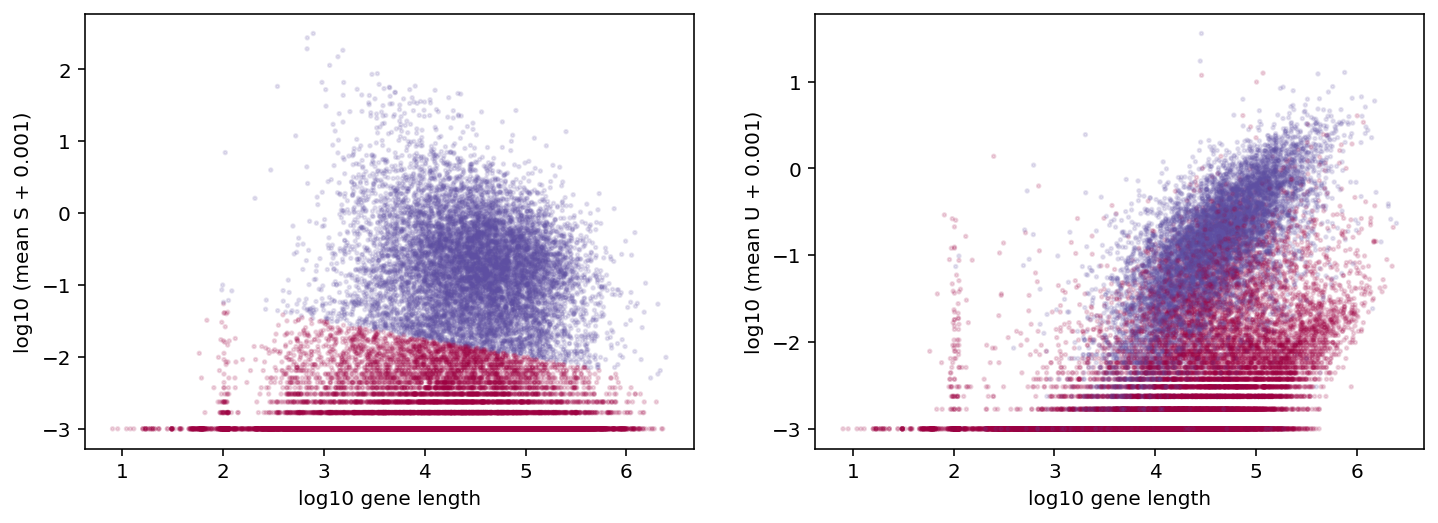

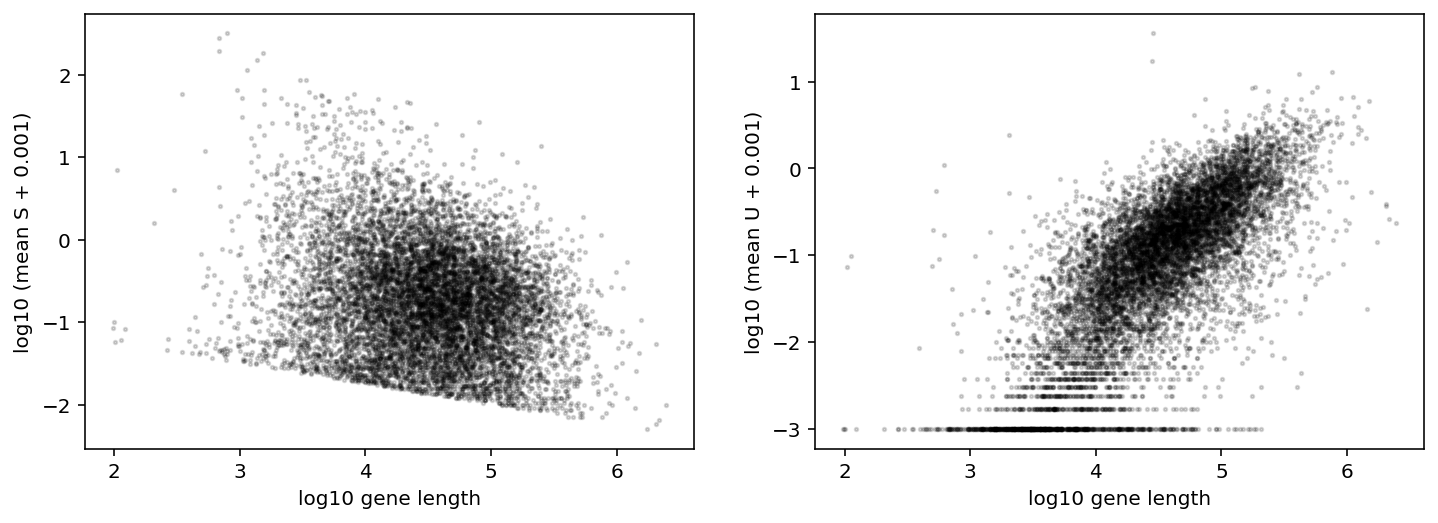

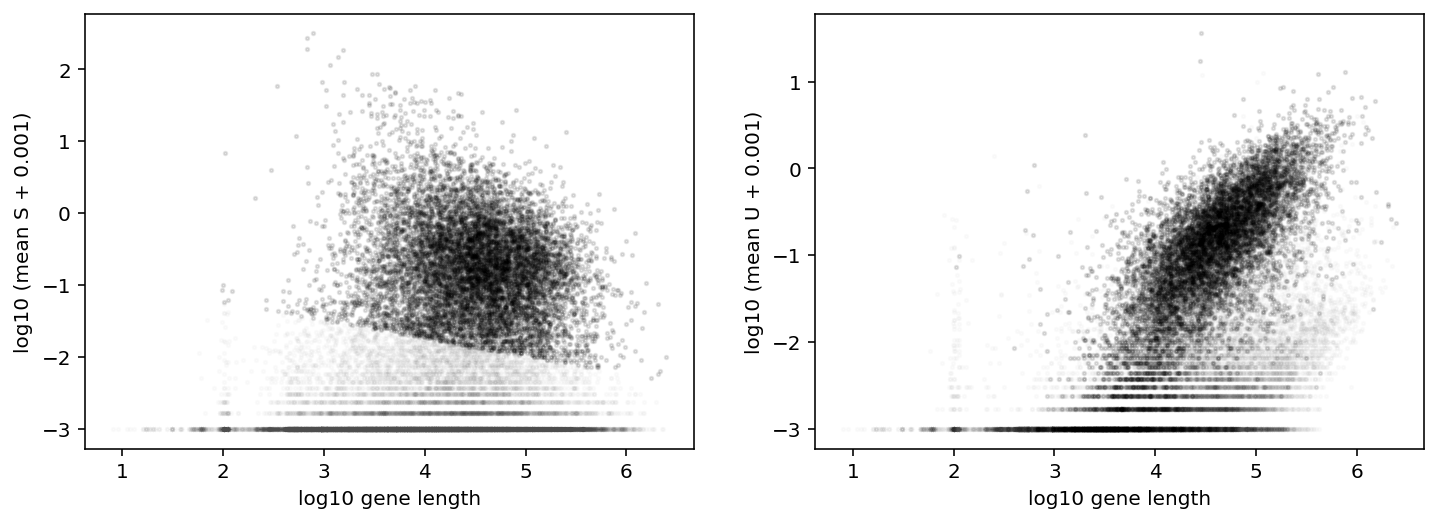

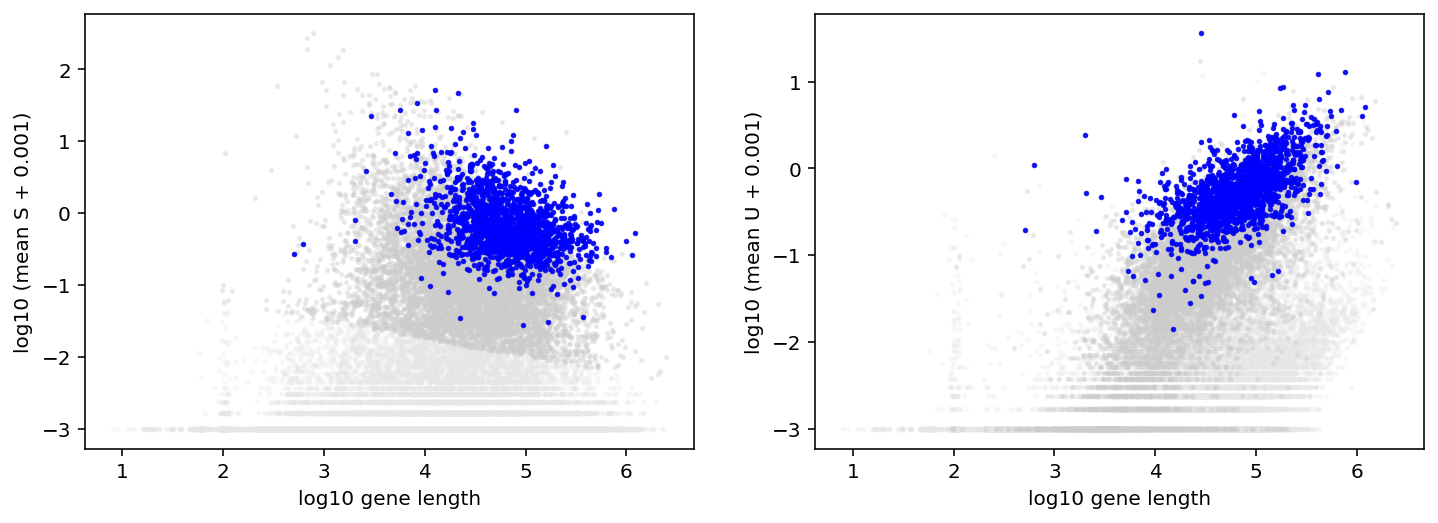

In [15]:
inference_workflow(looms[0]+'_input.txt')
#output looks ok, clear separation between high and low count genes

['/home/tchari/counts/replogle_crispr/loom/crisprsgHUS1a_sgFDPSb.loom']
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
1383 cells detected.
Directory /home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgHUS1a_sgFDPSb_10x11_1595gen_1 exists.
0 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 0.4 min.
['/home/tchari/counts/replogle_crispr/loom/crisprsgHUS1a_sgNegCtrl3b.loom']
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
983 cells detected.
Directory /home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgHUS1a_sgNegCtrl3b_10x11_1595gen_1 exists.
0 of 110 points to be evaluated.
Starting search...
Parallelization done!
Runtime: 0.4 min.
['/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgFDPSb.loom']
Beginning search routine.
36601 features observed, 36169 match genome annotations. 35727 are unique. 
1921 cells detected

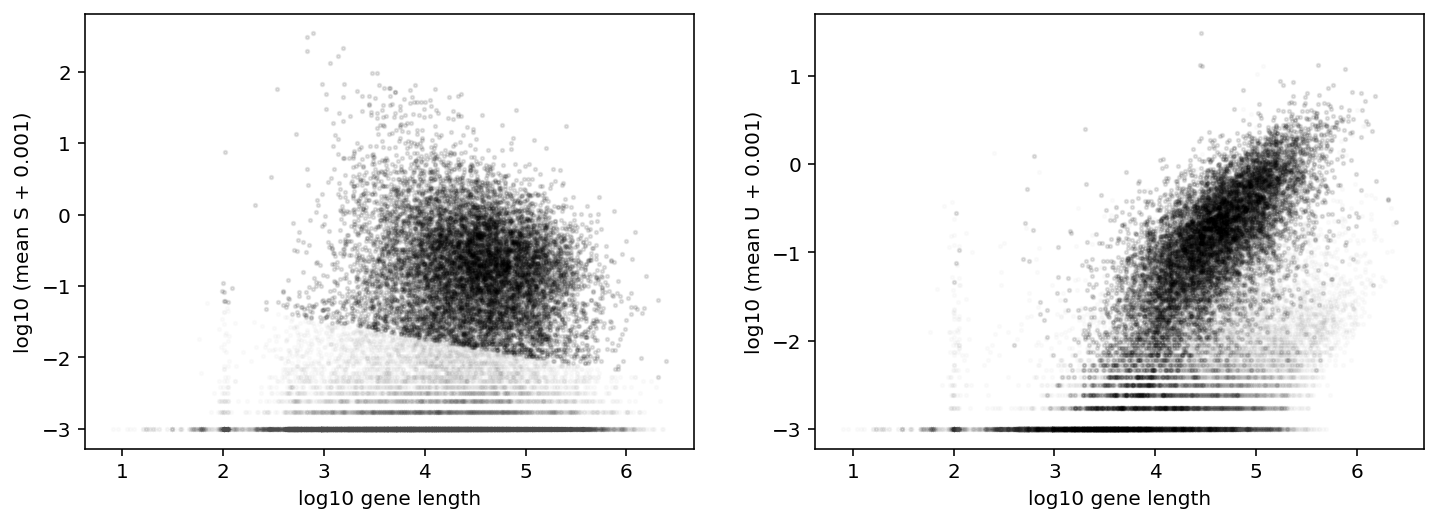

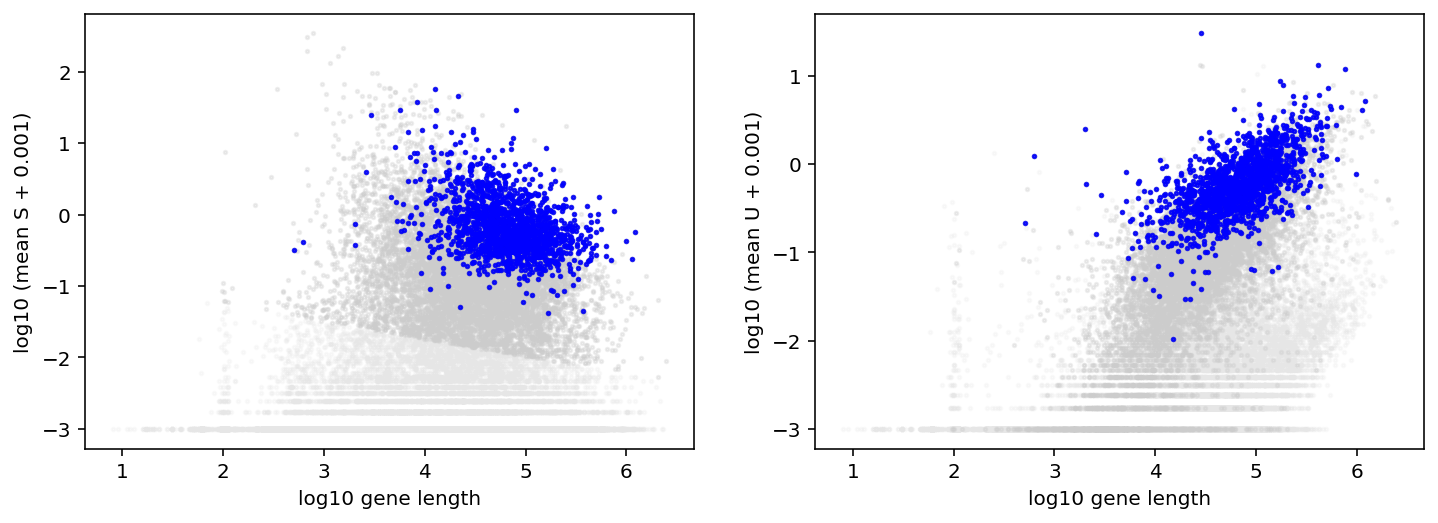

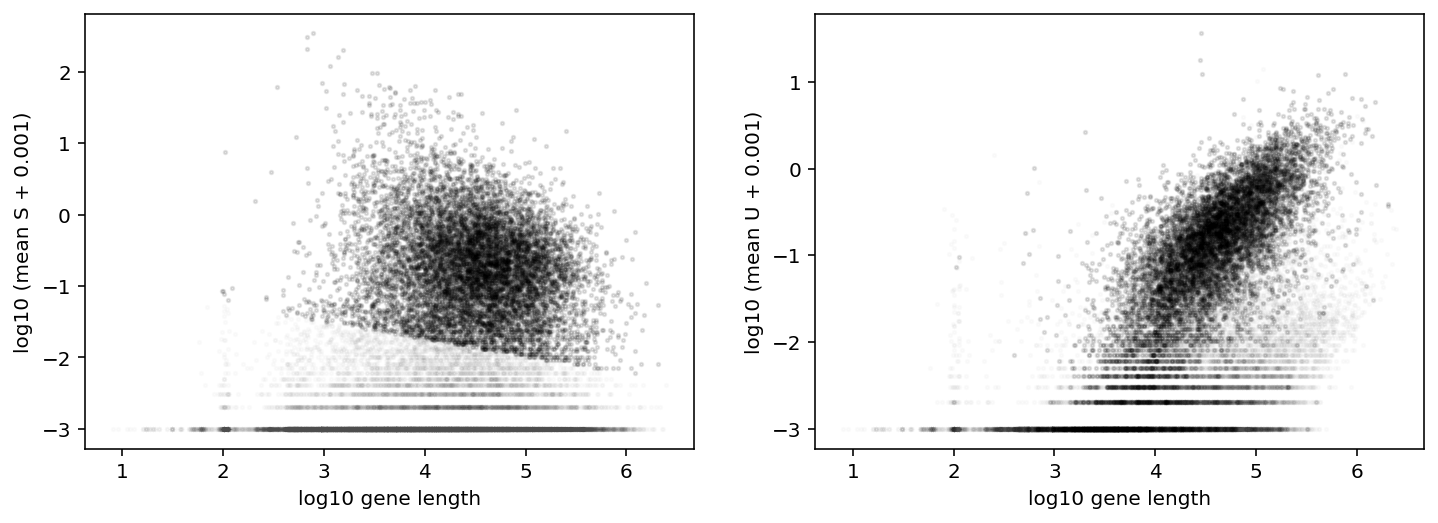

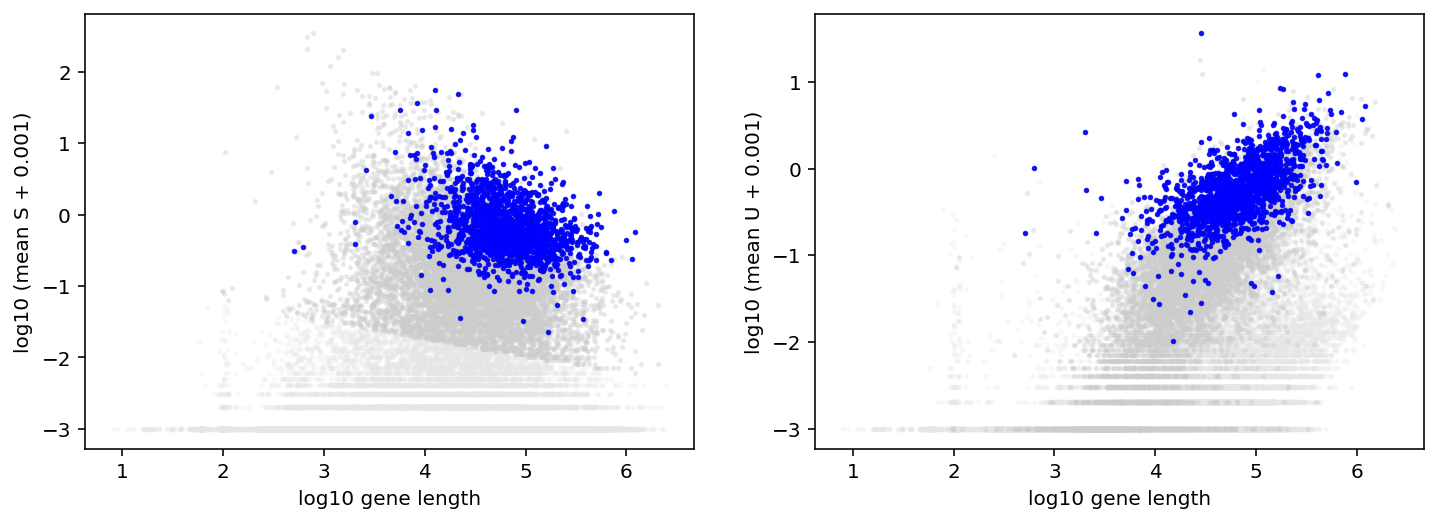

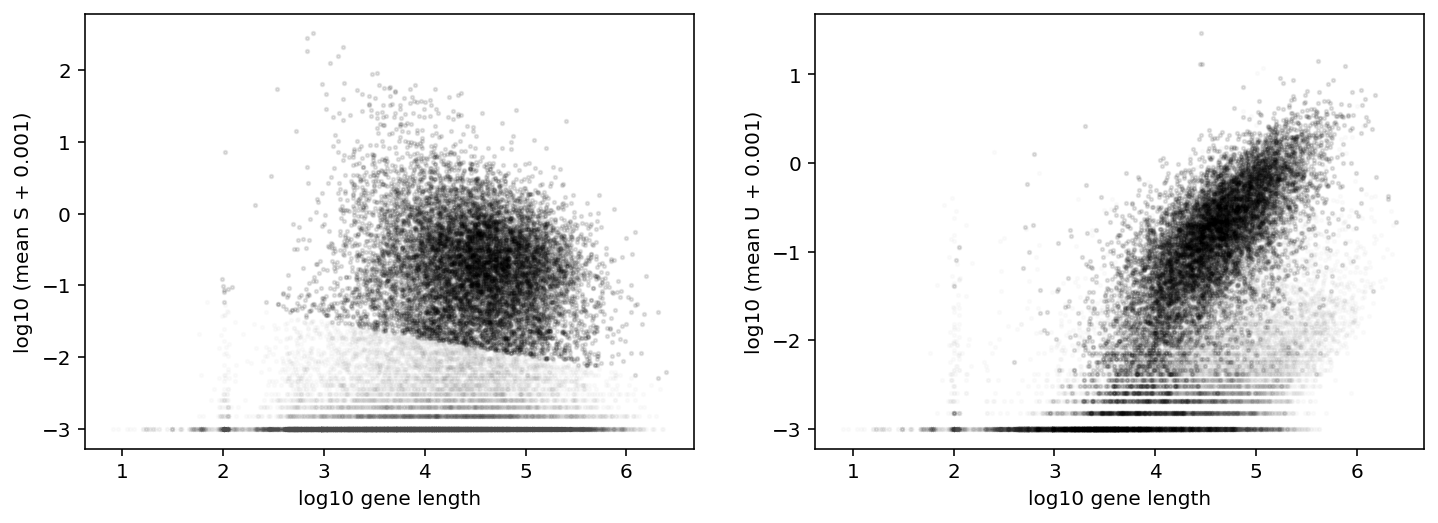

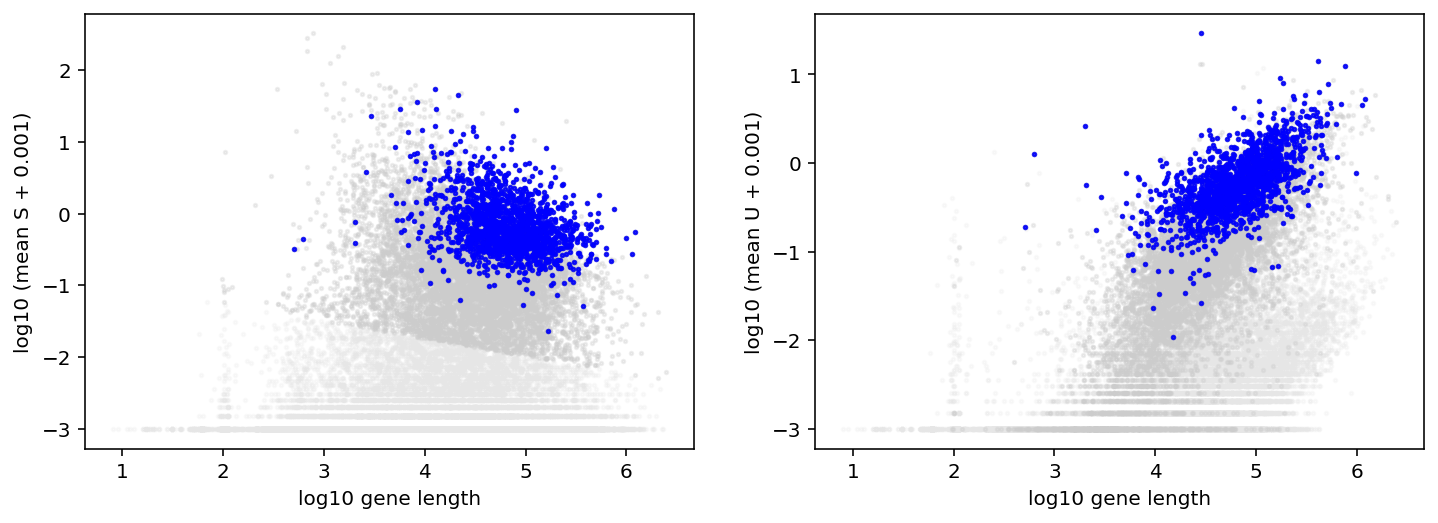

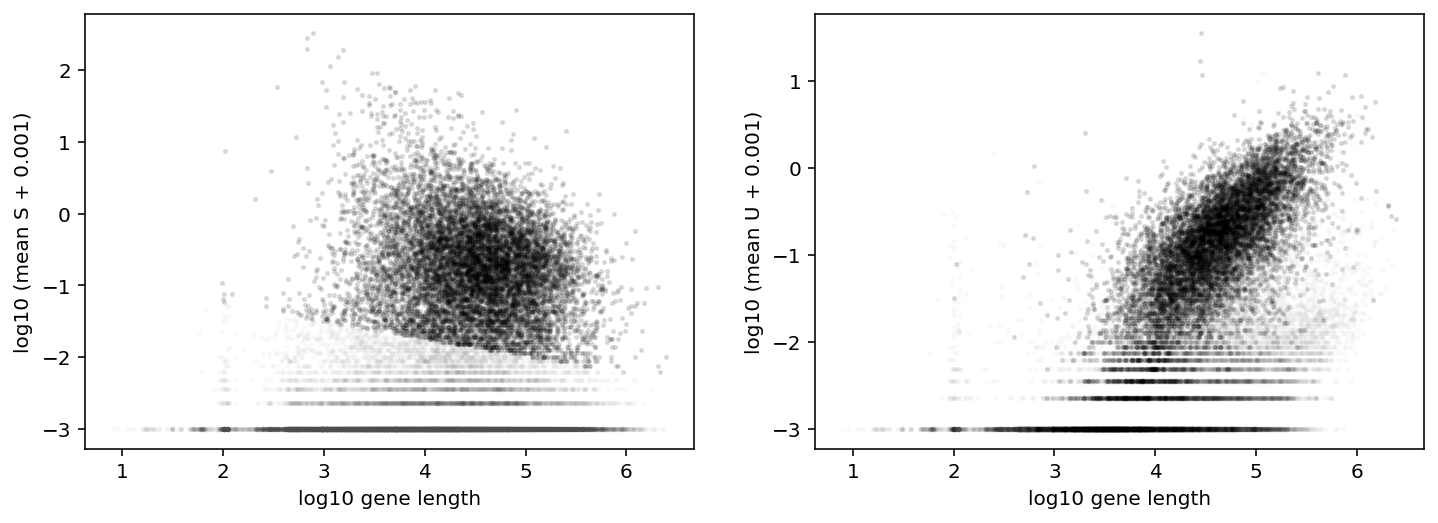

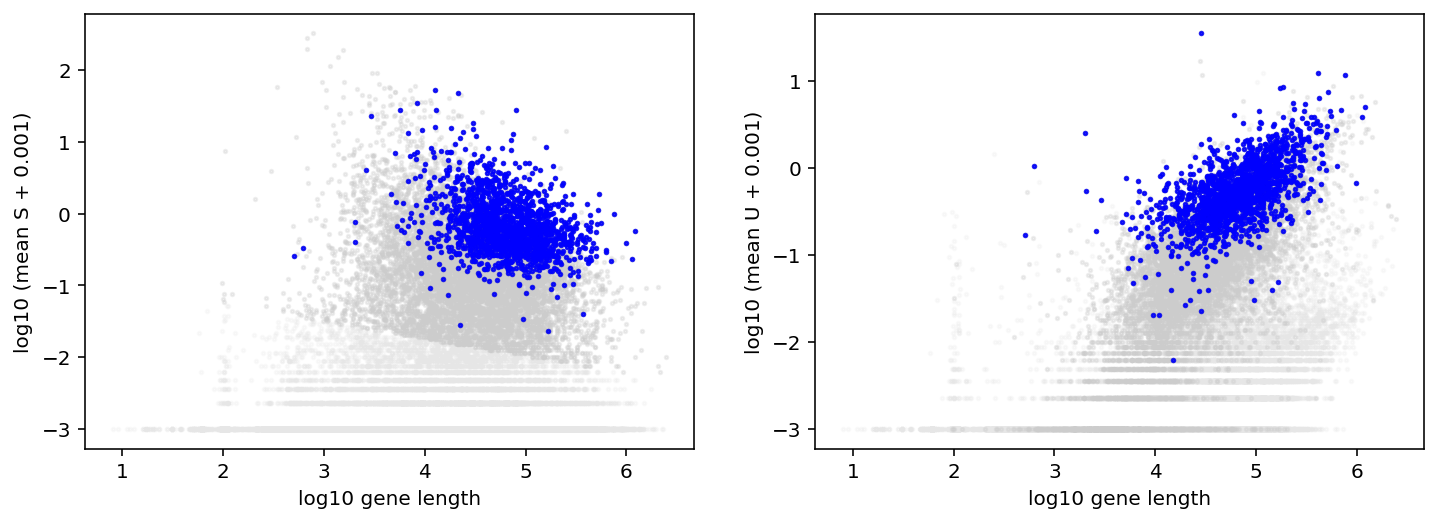

In [35]:
for i in range(1,len(looms)):
    genRunInput(fname=looms[i]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
                outDir=data_path+proj_fold+out_fold,loomName = looms[i],
                tranName = transcriptome,gList= selGenes+','+filtGenes,override=override)
    inference_workflow(looms[i]+'_input.txt')

## Result processing

### Set global parameters and read in data

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [6]:
# a e s t h e t i c s

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

In [7]:
def import_precomputed_(filestring):
    with open(filestring,'rb') as f:
        precomp = pickle.load(f)
    return precomp

def check_at_bounds(result_data,phys_params,thr=0.01):
    x = np.any(np.logical_or(
        result_data.search_params.lb_log+thr > phys_params,
        result_data.search_params.ub_log-thr < phys_params) ,1)
    return x


In [8]:
import glob

outputs = glob.glob(data_path+proj_fold+out_fold+creator+'_'+override+'_*/result.pickle')

In [9]:
outputs

['/home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgNegCtrl4a_sgNegCtrl3b_10x11_1595gen_1/result.pickle',
 '/home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgNegCtrl02093a_sgNegCtrl3b_10x11_1595gen_1/result.pickle',
 '/home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgNegCtrl02093a_sgFDPSb_10x11_1595gen_1/result.pickle',
 '/home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgHUS1a_sgFDPSb_10x11_1595gen_1/result.pickle',
 '/home/tchari/counts/replogle_crispr/loom_res/tc_run1_crisprsgHUS1a_sgNegCtrl3b_10x11_1595gen_1/result.pickle']

In [10]:
def get_name(fname):
    start = fname.find(data_path+proj_fold+out_fold+creator+'_'+override+'_') + len(data_path+proj_fold+out_fold+creator+'_'+override+'_')
    end = fname.find("_10x11")
    substring = fname[start:end]
    
    return substring

out_names = [get_name(i) for i in outputs]
out_names

['crisprsgNegCtrl4a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgFDPSb',
 'crisprsgHUS1a_sgFDPSb',
 'crisprsgHUS1a_sgNegCtrl3b']

In [11]:
#Read in outputs
results = []
for i in outputs:
     results += [import_datasets([i])]

results[0].raw_S.shape

(1595, 780)

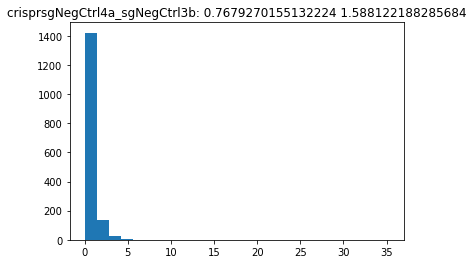

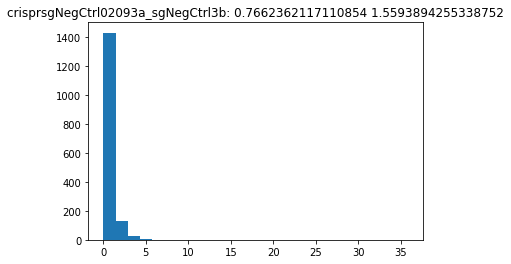

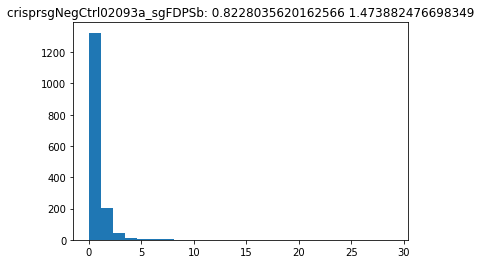

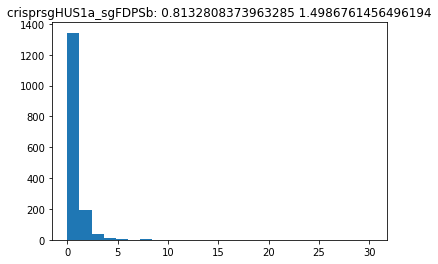

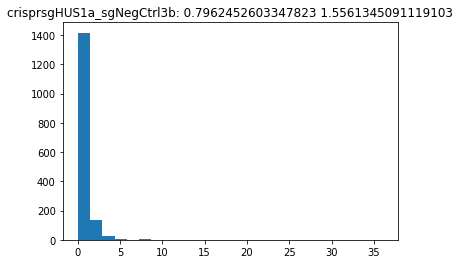

In [24]:
for i in range(len(results)):
    vals = np.sum(results[i].raw_U,axis = 1)/results[i].raw_U.shape[1]
    valsS = np.sum(results[i].raw_S,axis = 1)/results[i].raw_U.shape[1]
    plt.figure()
    plt.hist(vals.flatten(),bins=25)
    plt.title(out_names[i])
    plt.title(out_names[i]+': '+str(np.mean(vals.flatten())) + " " + str(np.mean(valsS.flatten())/np.mean(vals.flatten())))
    
    

### Data summary and exploration

Visualize the sampling parameter landscape. There is clearly an optimal basin in the $C_u, \lambda_s$ space, although the low resolution of the scan and the  number of genes make it challenging to identify it with much confidence.

crisprsgNegCtrl4a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgFDPSb
crisprsgHUS1a_sgFDPSb
crisprsgHUS1a_sgNegCtrl3b


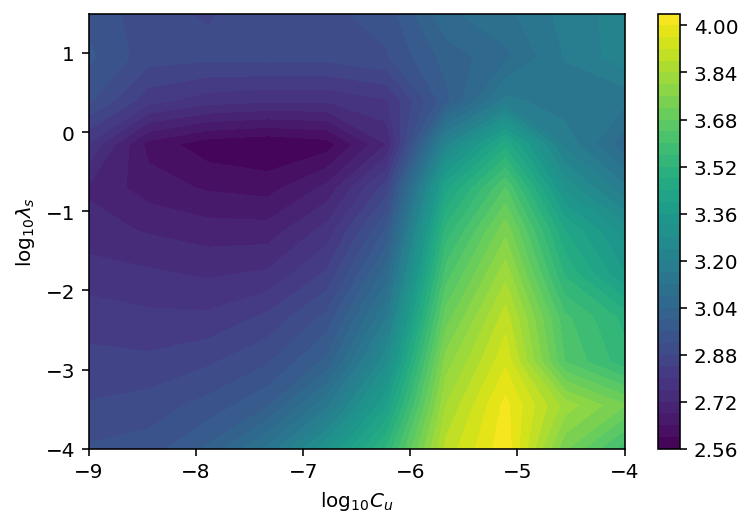

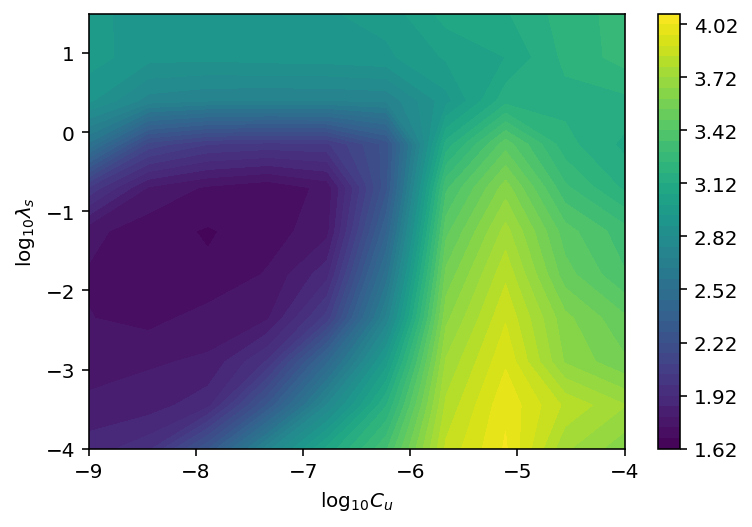

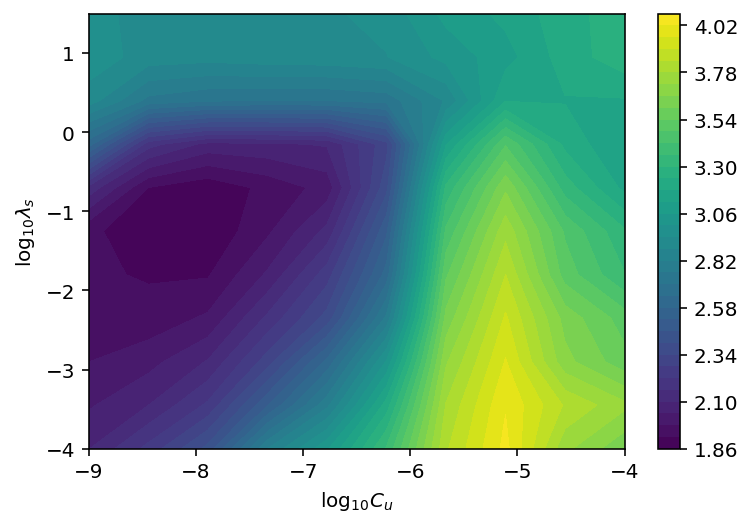

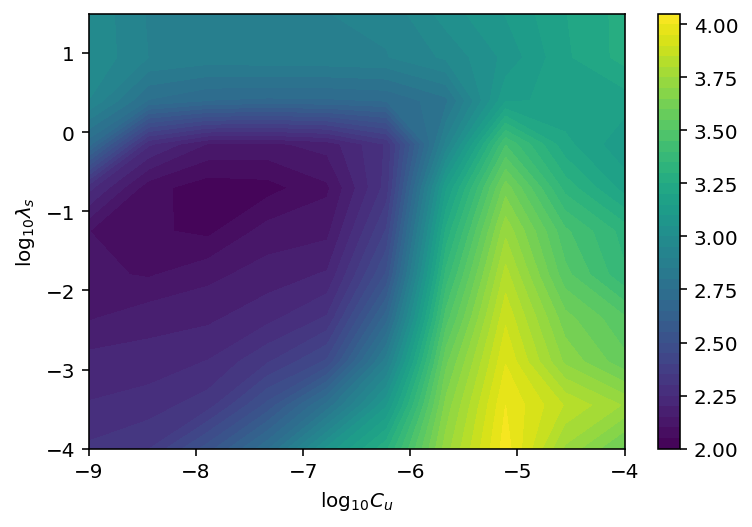

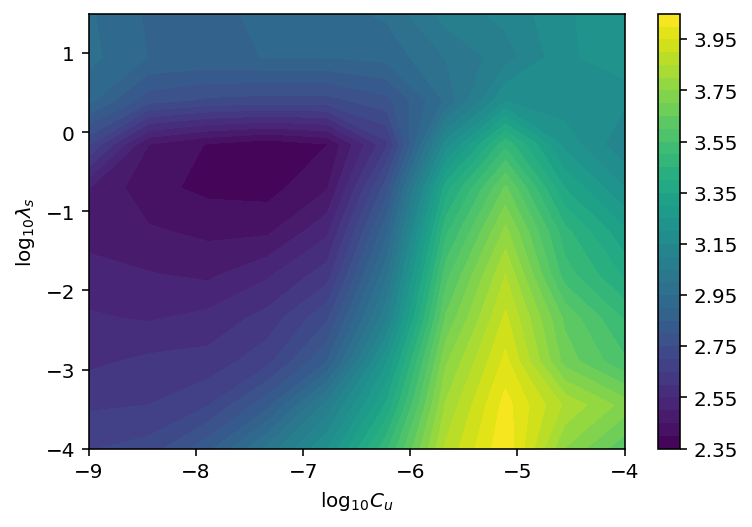

In [19]:
for i in range(0,len(results)):
    print(out_names[i])
    landscape_viz(results[i])

Compute the best parameter tuple using simple total KL divergence minimization. 

In [20]:
for i in range(0,len(results)):
    results[i].find_best_params()

In [21]:
for i in range(0,len(results)):
    print(out_names[i])
    print(results[i].best_samp_params)


crisprsgNegCtrl4a_sgNegCtrl3b
(-7.333333333333333, -0.14999999999999947)
crisprsgNegCtrl02093a_sgNegCtrl3b
(-7.888888888888889, -1.25)
crisprsgNegCtrl02093a_sgFDPSb
(-7.888888888888889, -1.25)
crisprsgHUS1a_sgFDPSb
(-7.888888888888889, -0.6999999999999997)
crisprsgHUS1a_sgNegCtrl3b
(-7.333333333333333, -0.14999999999999947)


Test the stability of the parameter optimum under resampling. Essentially, we subsample sets of genes and see how the landscape and its optimum change. The basin appears to be robust and well-defined with as few as 20 genes.

In [22]:
resamp_vec = np.array(np.linspace(0,results[0].n_gen,6)[1:-1],dtype=int)

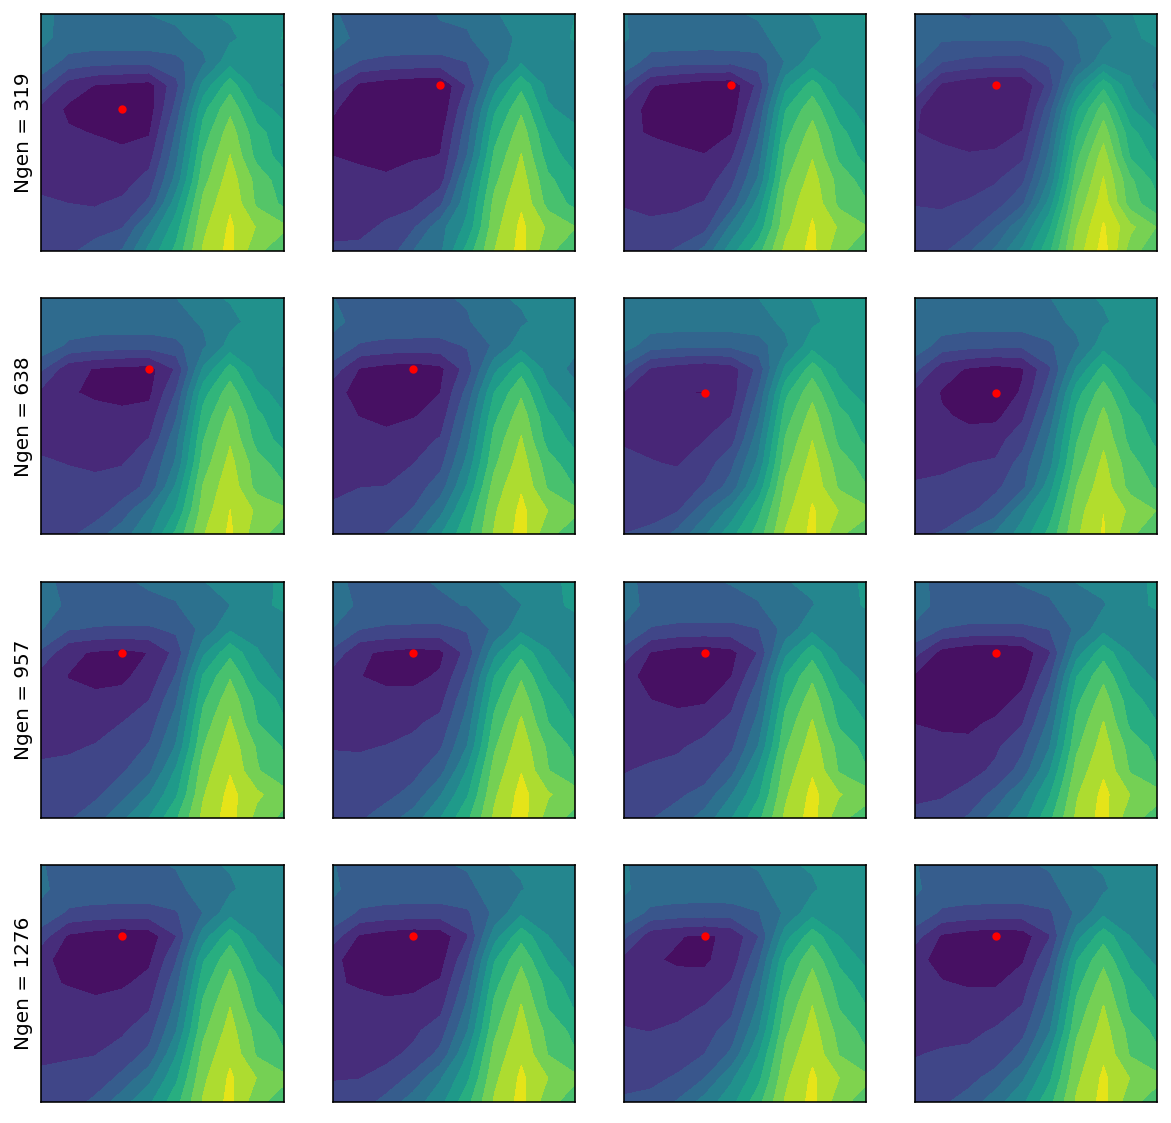

In [23]:
resample_opt_viz(results[-1],resamp_vec)

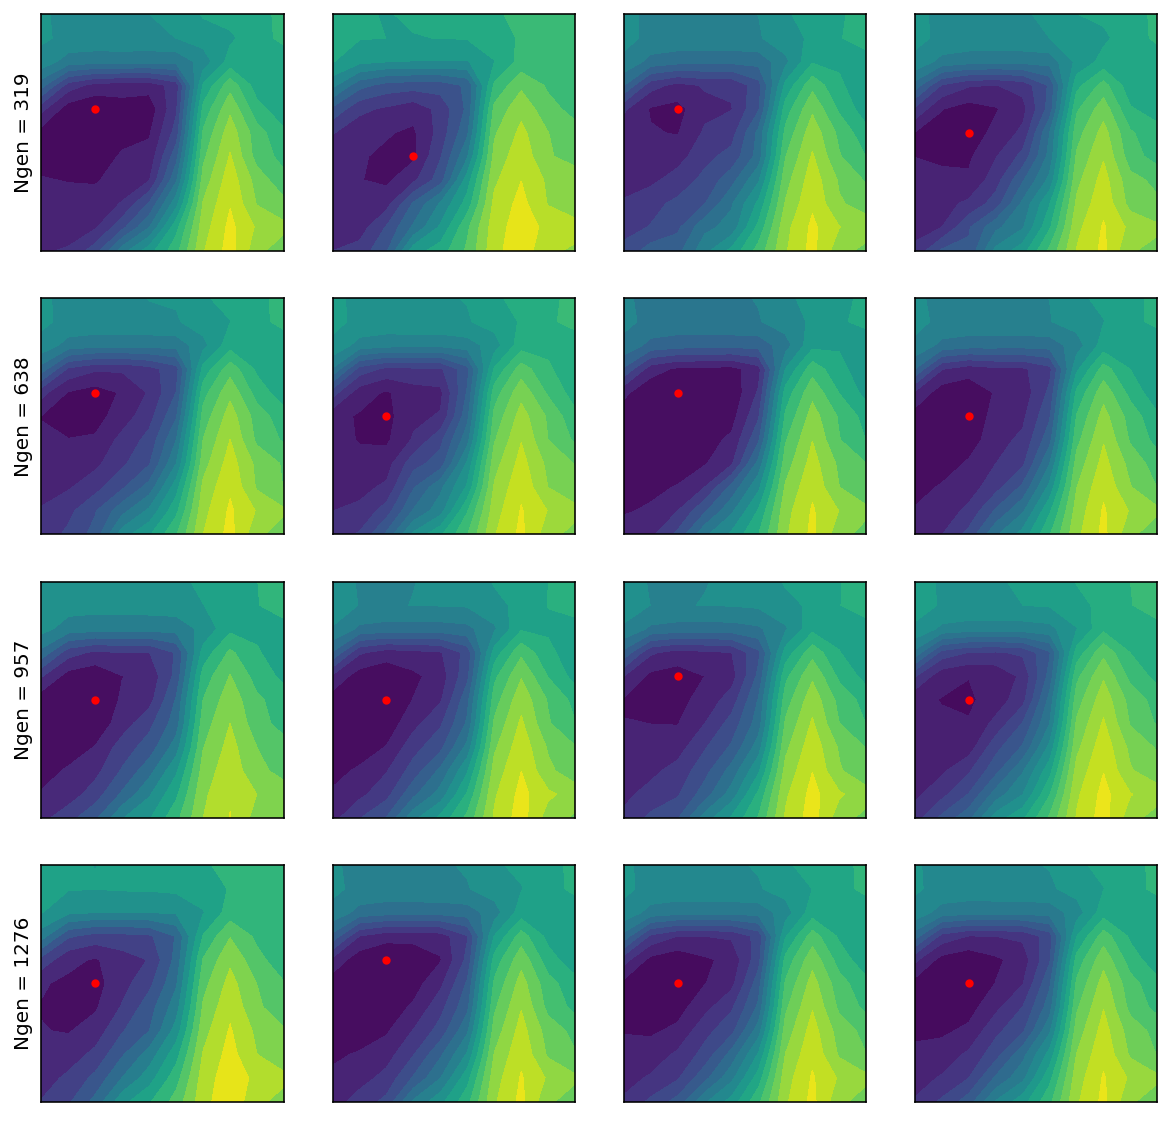

In [24]:
resample_opt_viz(results[2],resamp_vec)

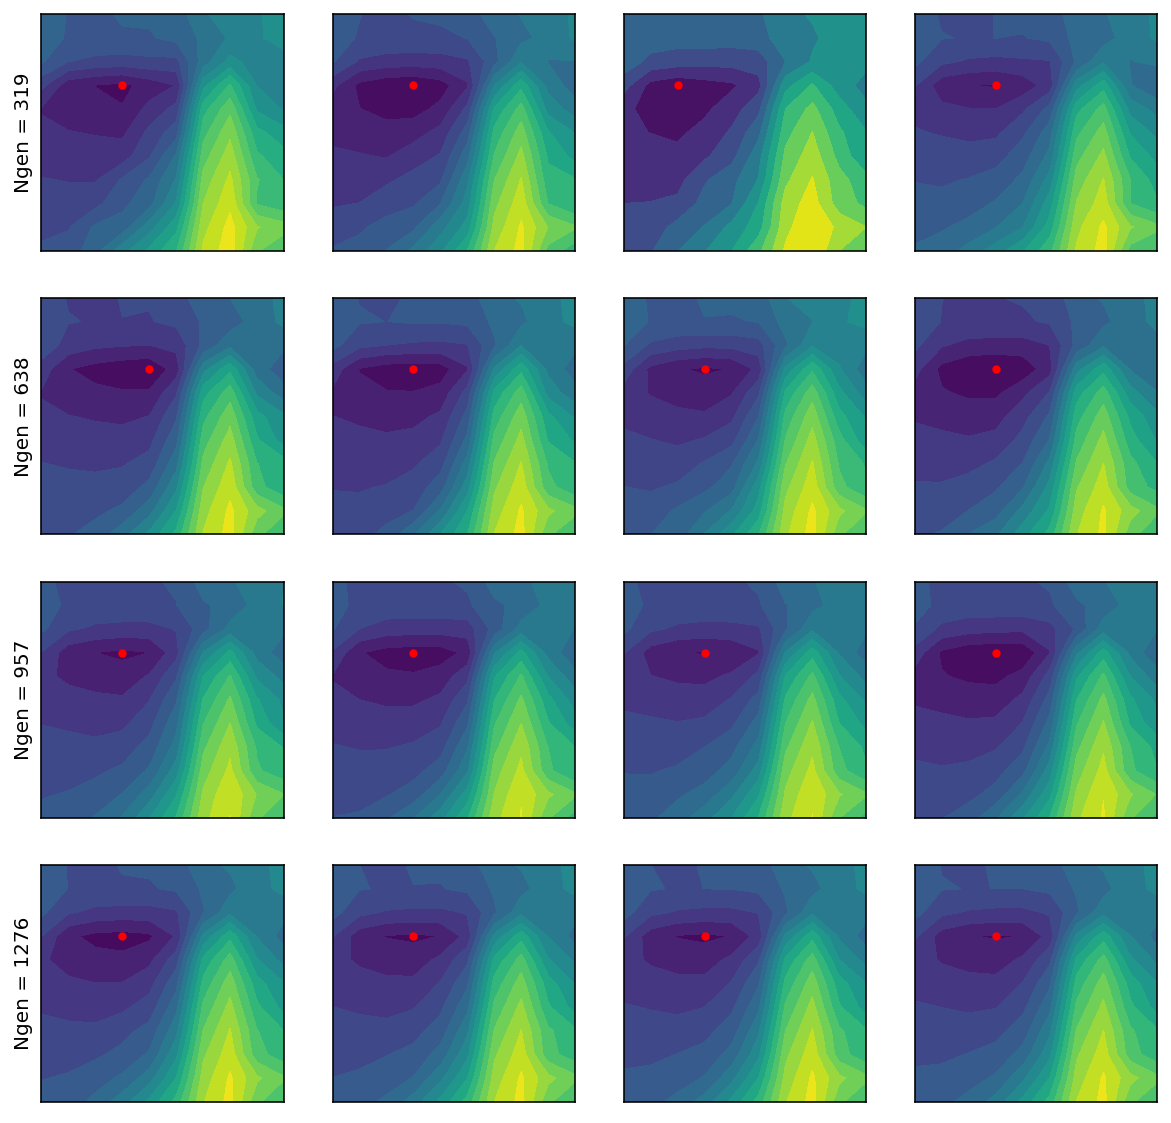

In [25]:
resample_opt_viz(results[0],resamp_vec)

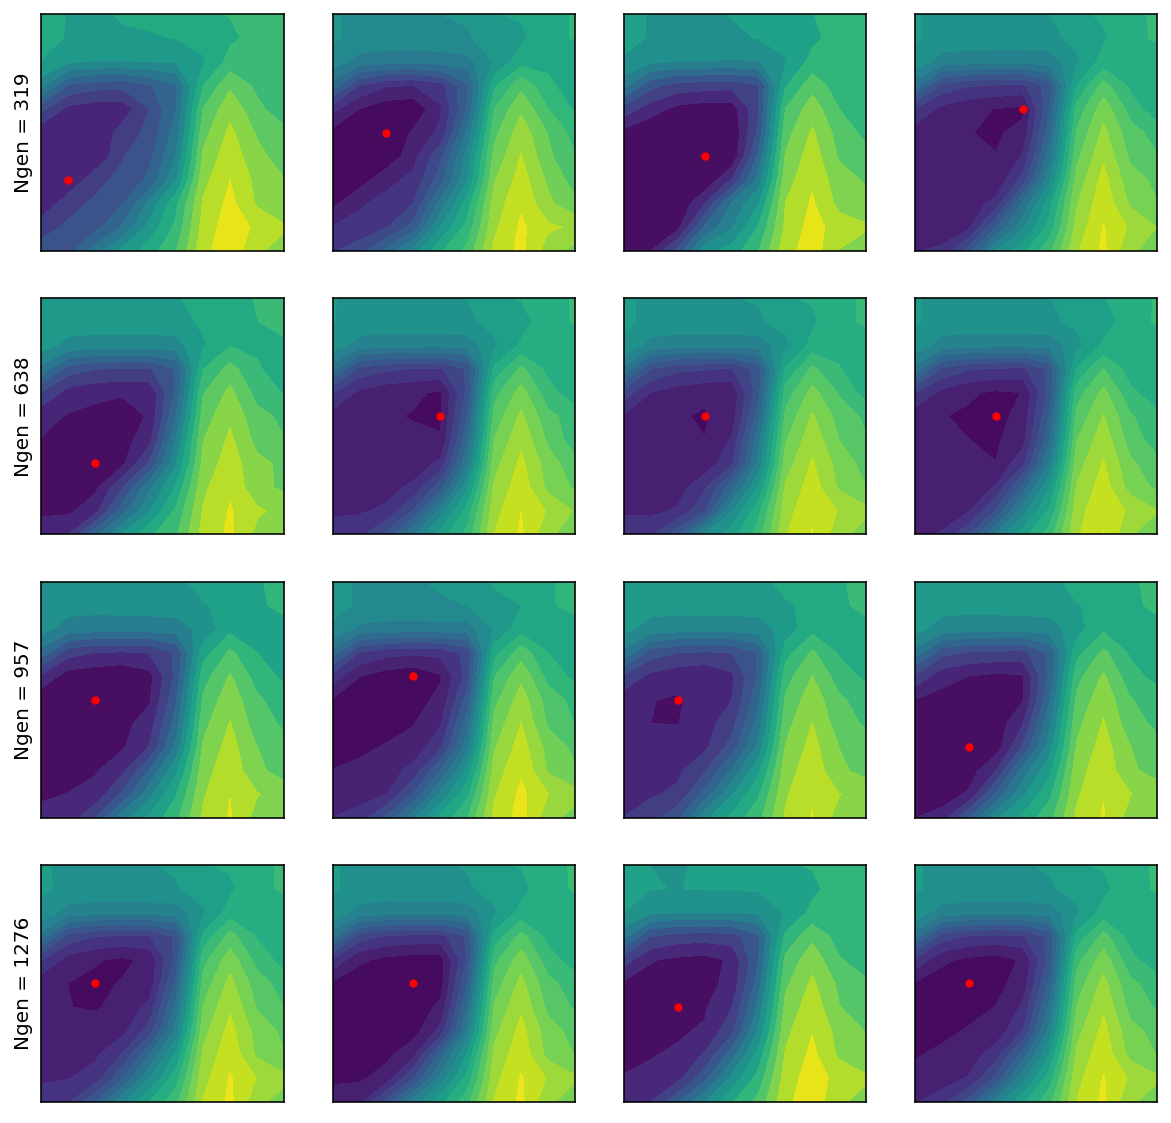

In [26]:
resample_opt_viz(results[1],resamp_vec)

Summarize these findings by resampling 1000 times and plotting the locations of the optima.

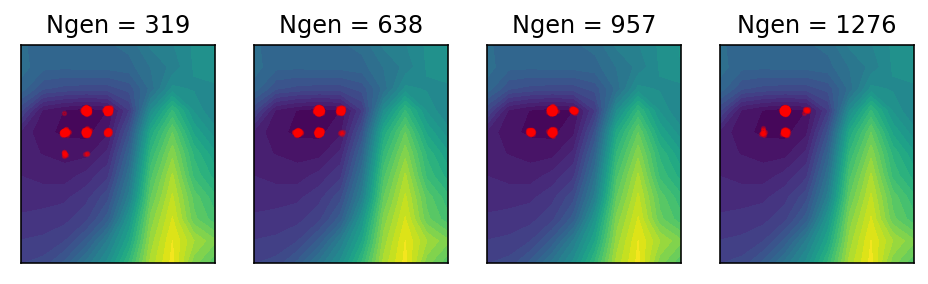

In [21]:
resample_opt_mc_viz(results[-1],resamp_vec)

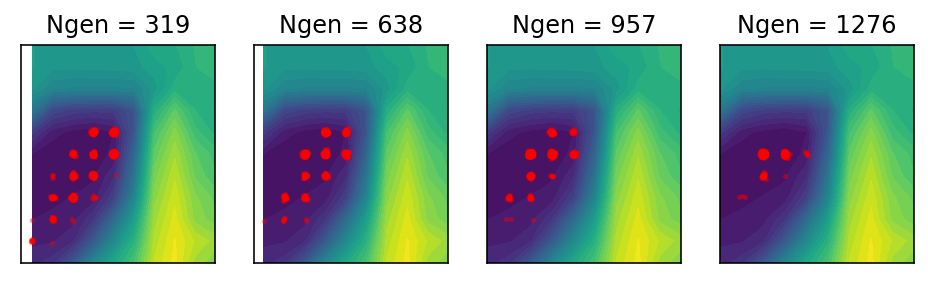

In [22]:
resample_opt_mc_viz(results[0],resamp_vec)

Plot a normal-inverse Gaussian fit to the parameters, with and without sampling. The parameters clearly show quite a bit of skewness.

crisprsgNegCtrl4a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgFDPSb
crisprsgHUS1a_sgFDPSb
crisprsgHUS1a_sgNegCtrl3b


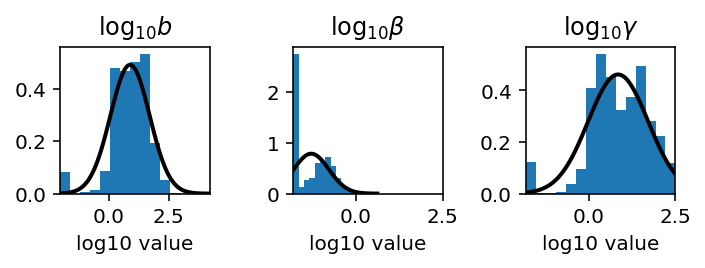

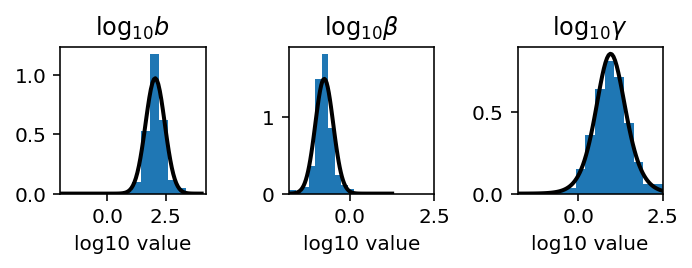

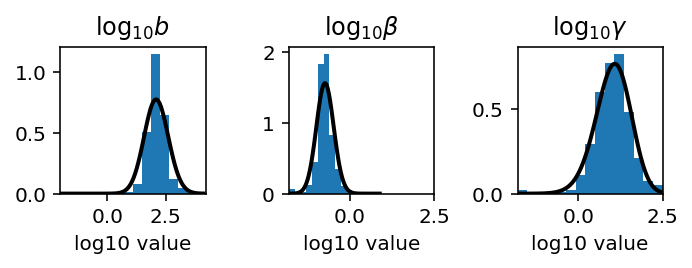

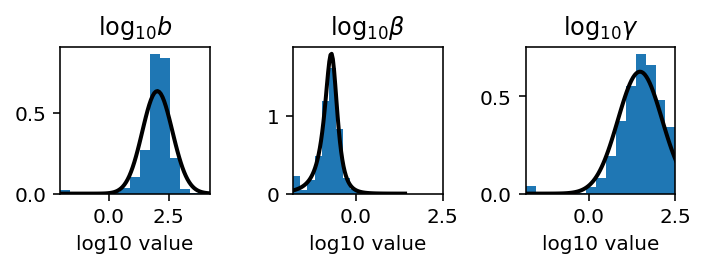

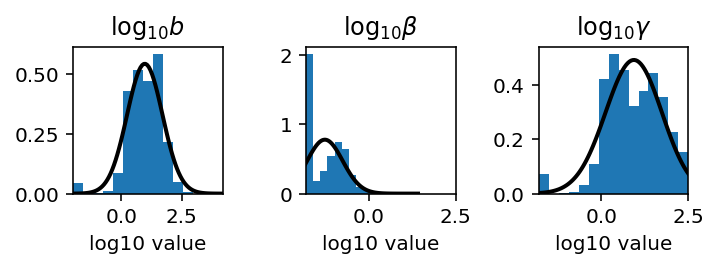

In [27]:
from scipy.stats import *
for i in range(0,len(results)):
    print(out_names[i])
    plot_param_marg(results[i],fitlaw=norminvgauss)

Perform the same analysis on the noise-free results. The burst size parameters are shifted down by roughly an order of magnitude.

crisprsgNegCtrl4a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgNegCtrl3b
crisprsgNegCtrl02093a_sgFDPSb
crisprsgHUS1a_sgFDPSb
crisprsgHUS1a_sgNegCtrl3b


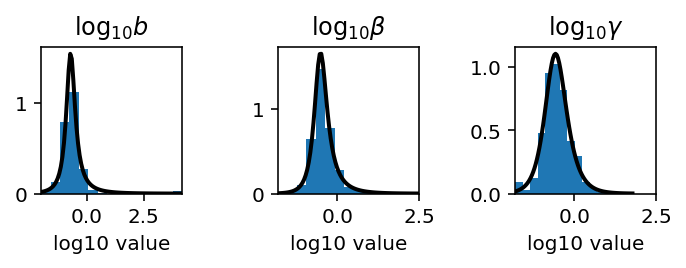

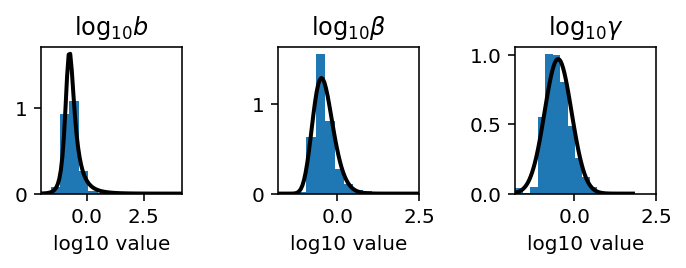

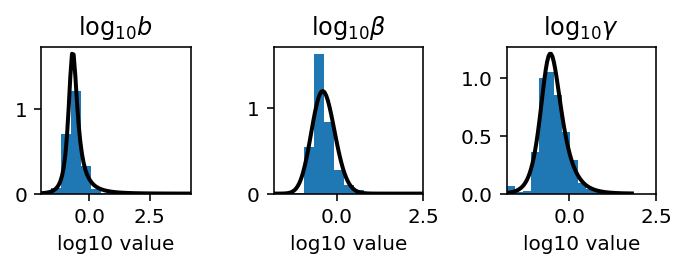

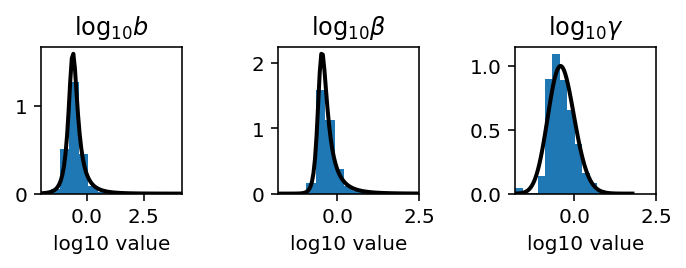

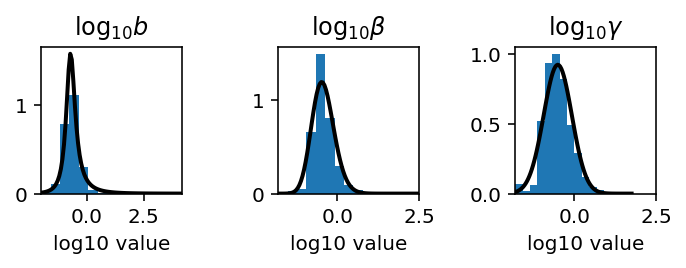

In [28]:
for i in range(0,len(results)):
    print(out_names[i])
    plot_param_marg(results[i],nosamp=True,fitlaw=norminvgauss)

Examine length dependence (without error bars on maximum likelihood estimates). The full technical noise model does not appear to show much length dependence -- apart from, perhaps, a very modest decrease in burst size. The noise-free model shows that the burst size increases with length.

In [57]:
# fo
# result_data_0.best_phys_params
# params_1 = result_data_1.best_phys_params
# params_both = result_data_both.best_phys_params

In [29]:
for i in range(0,len(results)):
    chisq_gen(results[i])
    compute_sigma(results[i])

Parameter set 1 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 4 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 118 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 167 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 186 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 232 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 254 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 270 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 288 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 317 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 335 gives negative s

Parameter set 7 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 45 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 184 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 211 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 273 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 339 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 341 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 373 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 381 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 407 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 446 gives negative 

In [30]:
from matplotlib.colors import ListedColormap
c_highlight = col_red
c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=20
cmap = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

In [31]:
import itertools
combinations_object = itertools.combinations(range(0,len(results)), 2)
rep_pairs = list(combinations_object)
rep_pairs # Pairs of samples to compare

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

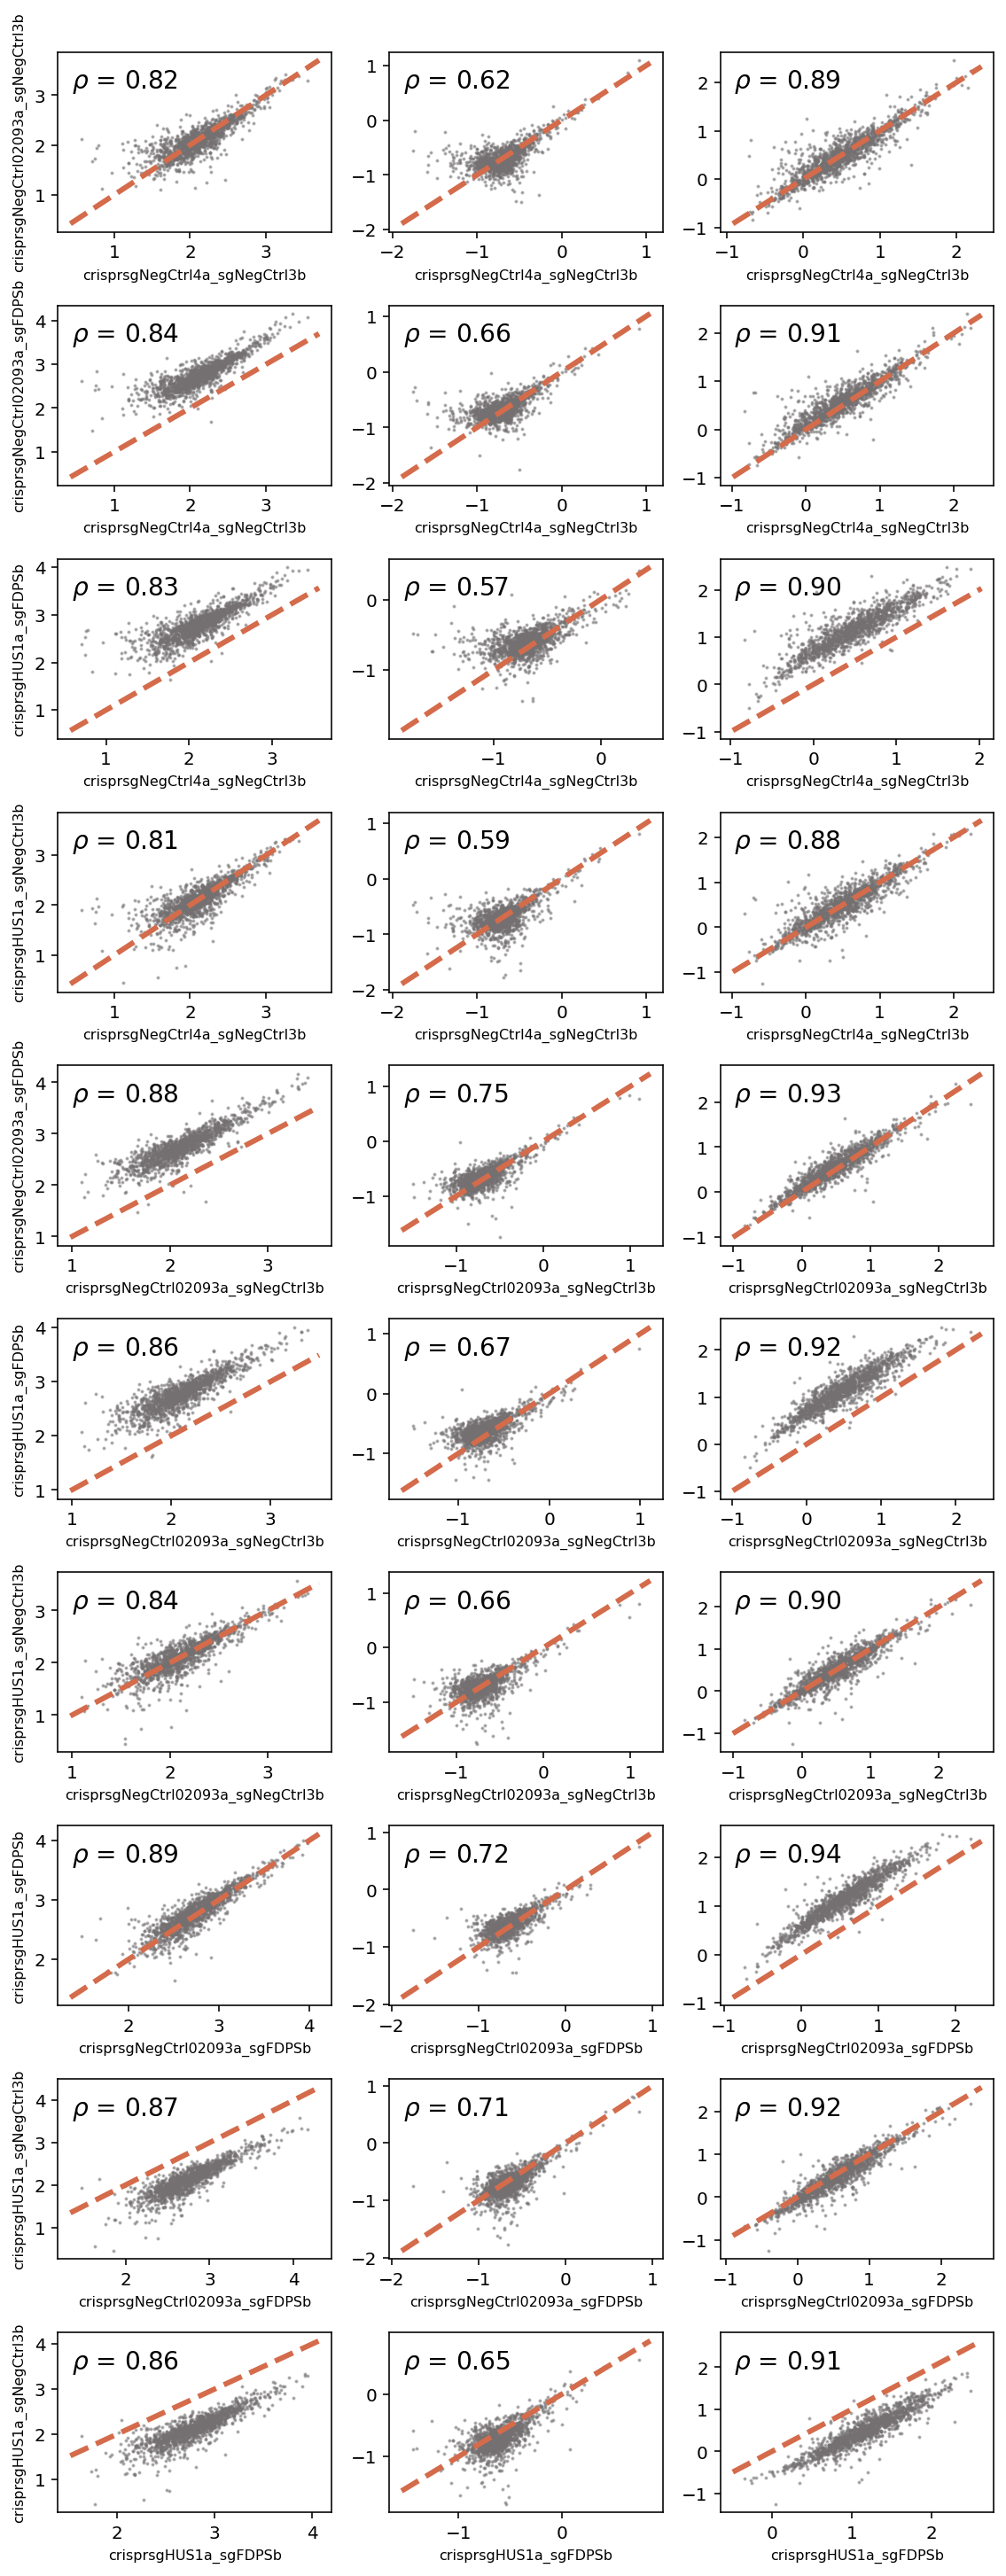

In [56]:
ms,lw,ms_fail,alf,alf_fail = sifig_aesth
fig1, ax1 = plt.subplots(nrows=len(rep_pairs),ncols=3,figsize=(8,20))
nbin=30
for i in range(len(rep_pairs)):
    K = rep_pairs[i]
    #print(looms[K[0]])
    res1 = results[K[0]]#import_precomputed_(results[K[0]])


    #print(looms[K[1]])
    res2 = results[K[1]]#import_precomputed_(results[K[1]])
    #chisq_gen(res2)

    err1 = res1.sigma*2.576
    err2 = res2.sigma*2.576


    for j in range(3):
        filt = ~res1.gene_rej & ~res2.gene_rej \
            & ~check_at_bounds(res1,res1.best_phys_params)\
            & ~check_at_bounds(res2,res2.best_phys_params)
#         ax1[i,j].errorbar(res1.best_phys_params[filt,j],
#             res2.best_phys_params[filt,j],
#             err1[filt,j],err2[filt,j],marker=markerstyle,ms=ms,c=col_gold,alpha=alf,linestyle='None',linewidth=lw,zorder=-100)
        ax1[i,j].scatter(res1.best_phys_params[filt,j],
                   res2.best_phys_params[filt,j],color=col_gray,alpha=alf_fail,s=ms_fail)


        fs=14
        sml=8
        rho=np.corrcoef(res1.best_phys_params[filt,j],res2.best_phys_params[filt,j])[0][1]
        xl = ax1[i,j].get_xlim()
        ax1[i,j].plot(xl,xl,'--',color=c_highlight,linewidth=3)
        ax1[i,j].set_xlabel(out_names[K[0]],fontsize=sml)

        if j==0:
            ax1[i,j].set_ylabel(out_names[K[1]],fontsize=sml)
        ax1[i,j].text(.05,.8,r'$\rho$ = {:.2f}'.format(rho),fontsize=fs,transform=ax1[i,j].transAxes)

fig1.tight_layout()
fig1.show()

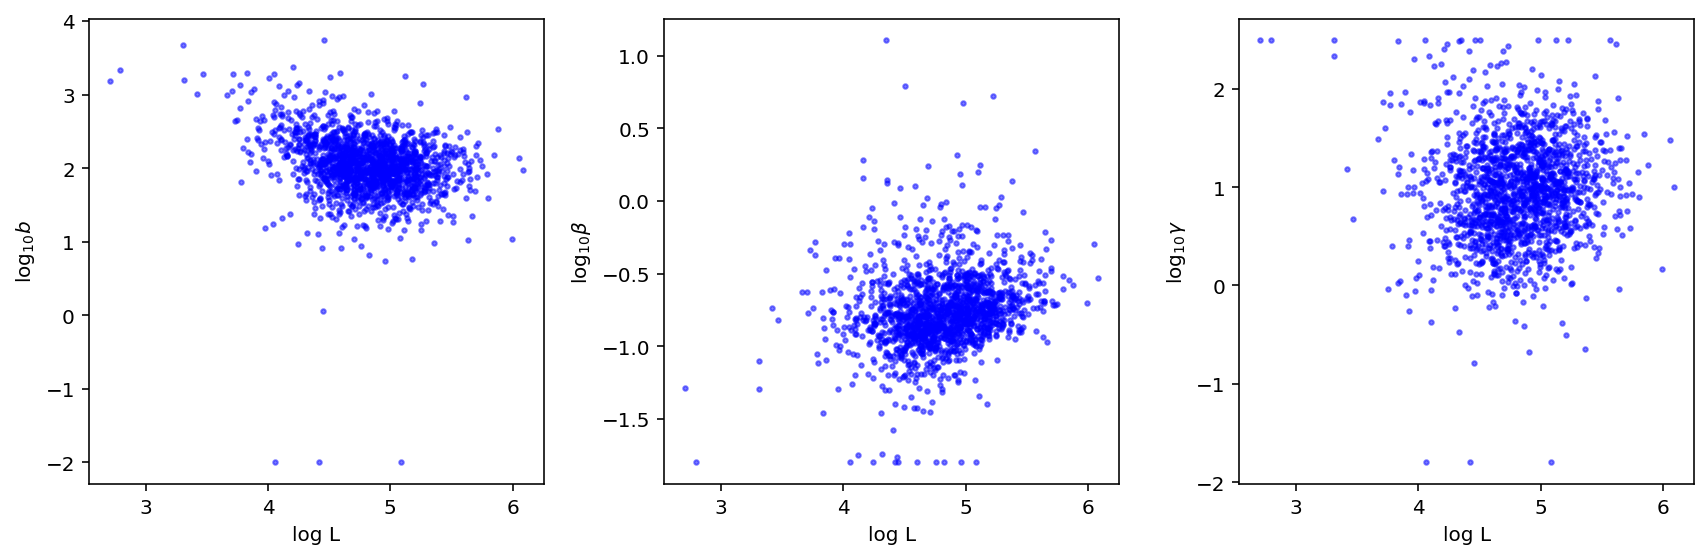

In [37]:
plot_param_L_dep(results[0],plot_errorbars=False)

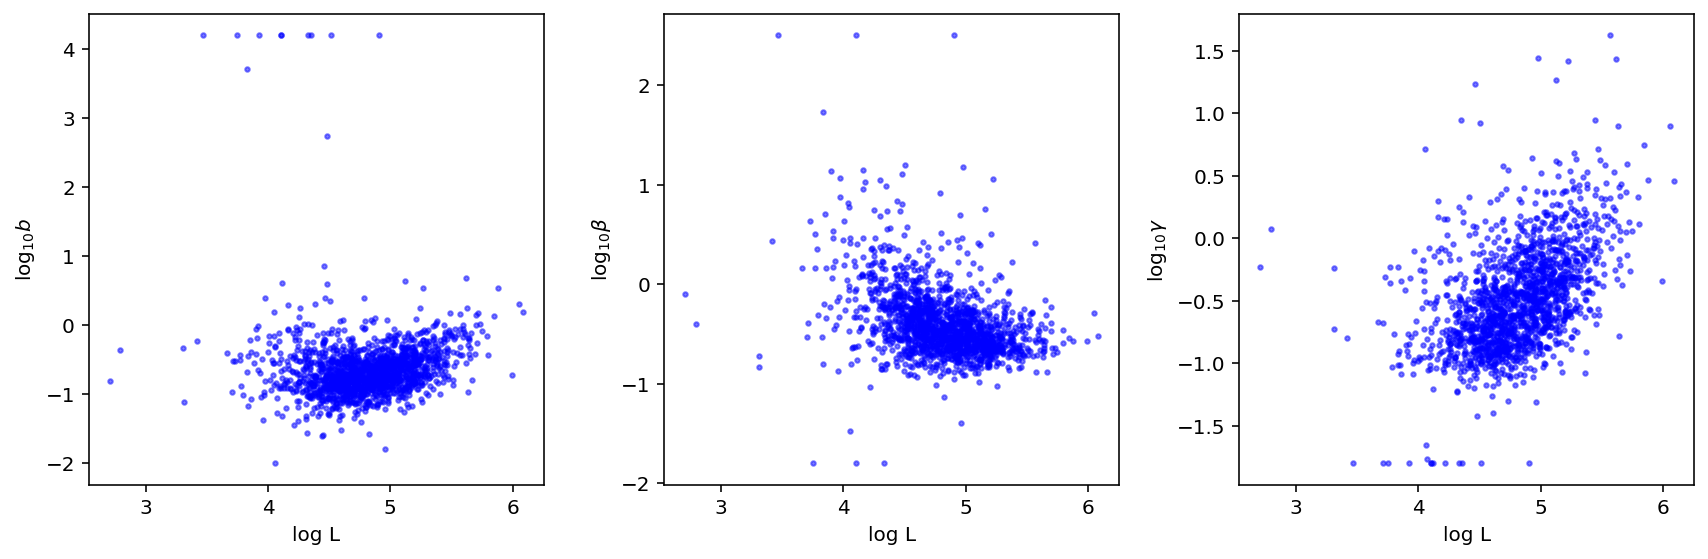

In [38]:
plot_param_L_dep(results[0],plot_errorbars=False,nosamp=True,chisq_correct=False) # see length dep.

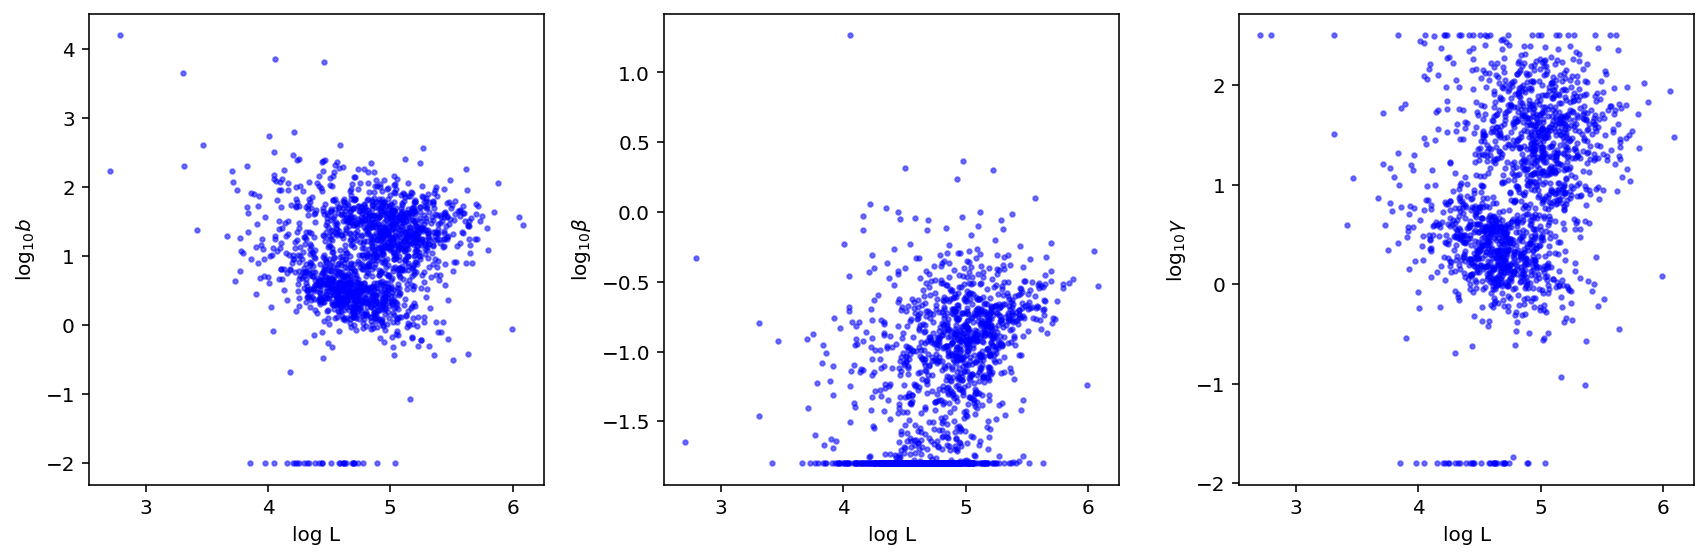

In [39]:
plot_param_L_dep(results[-1],plot_errorbars=False)

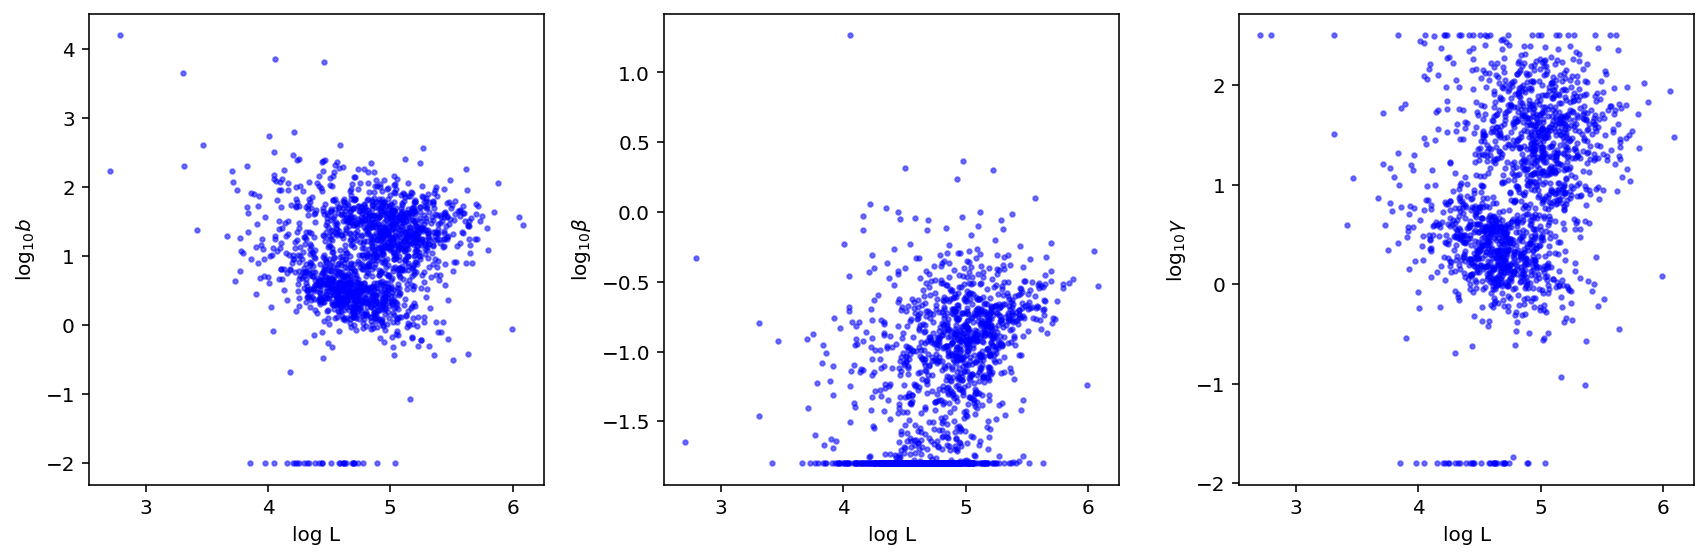

In [39]:
plot_param_L_dep(results[-1],plot_errorbars=False,nosamp=True,chisq_correct=False)

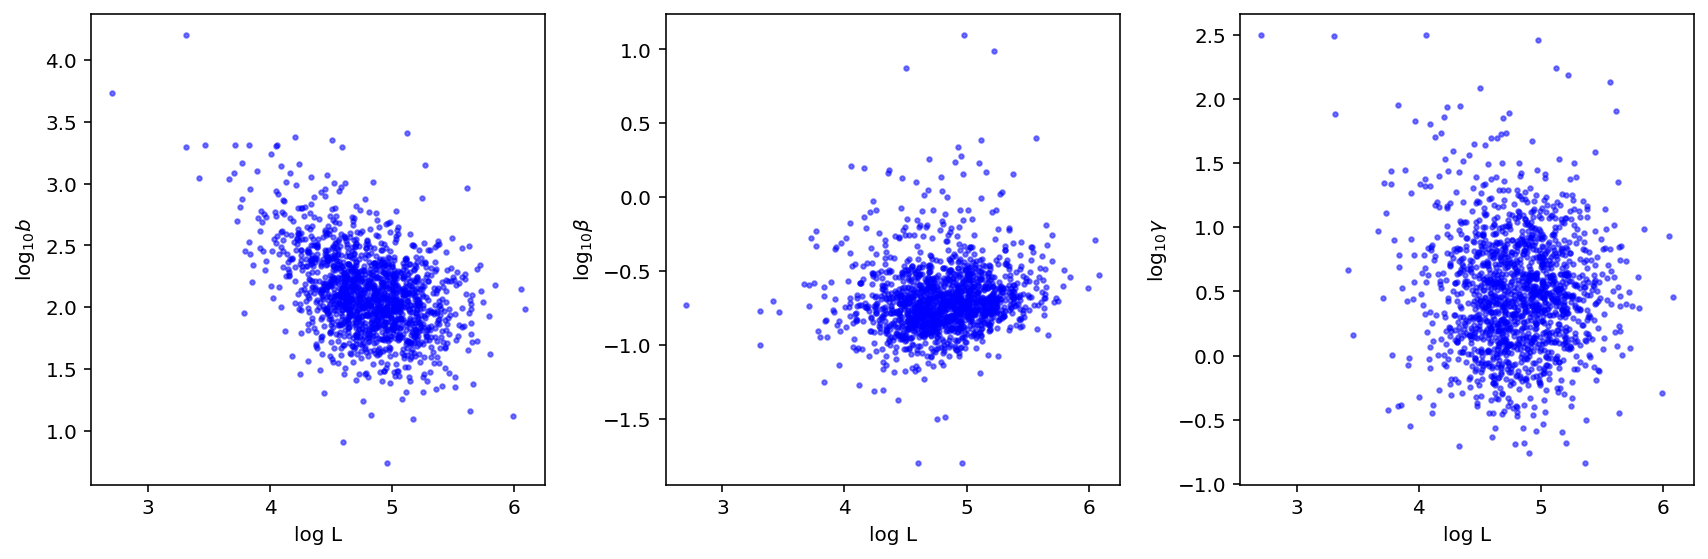

In [60]:
plot_param_L_dep(results[1],plot_errorbars=False) 

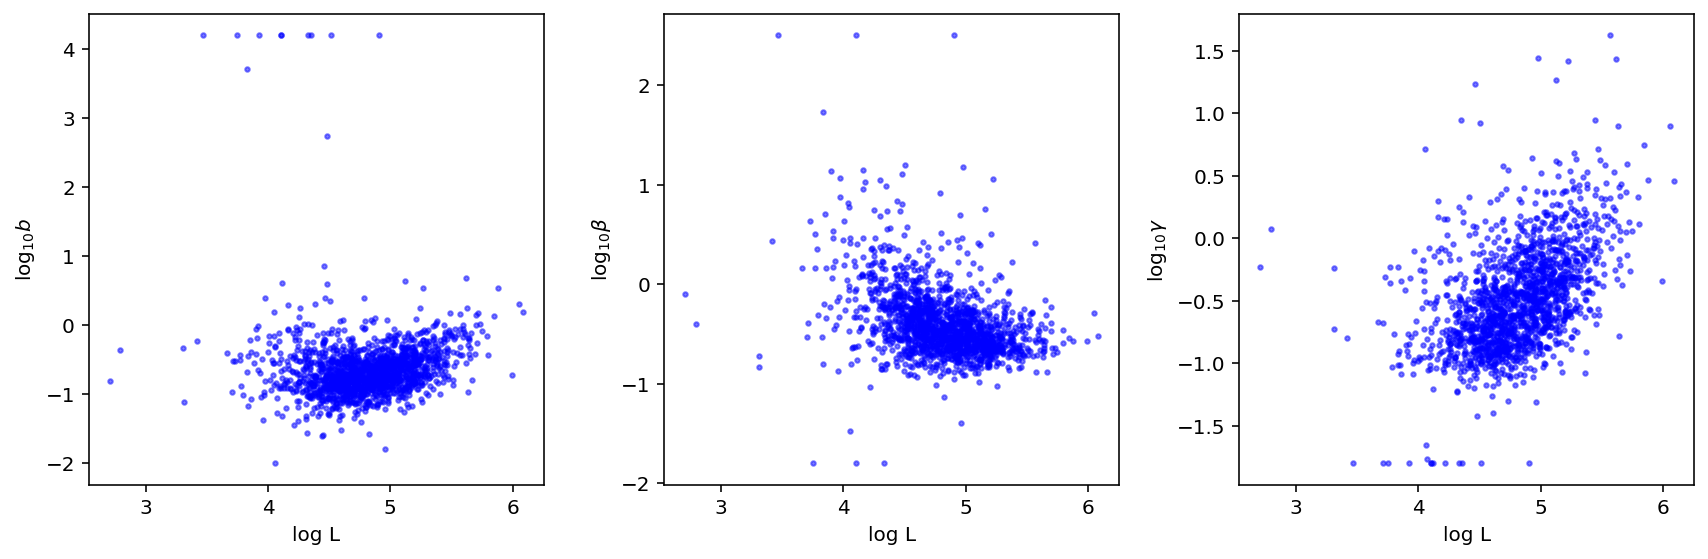

In [58]:
plot_param_L_dep(results[1],plot_errorbars=False,nosamp=True,chisq_correct=False) #See length dep.

### Fit quality analysis

Investigate the distribution of KL divergences at the optimal grid point. Only a few genes seem to have obviously poor fits (high KL divergence).

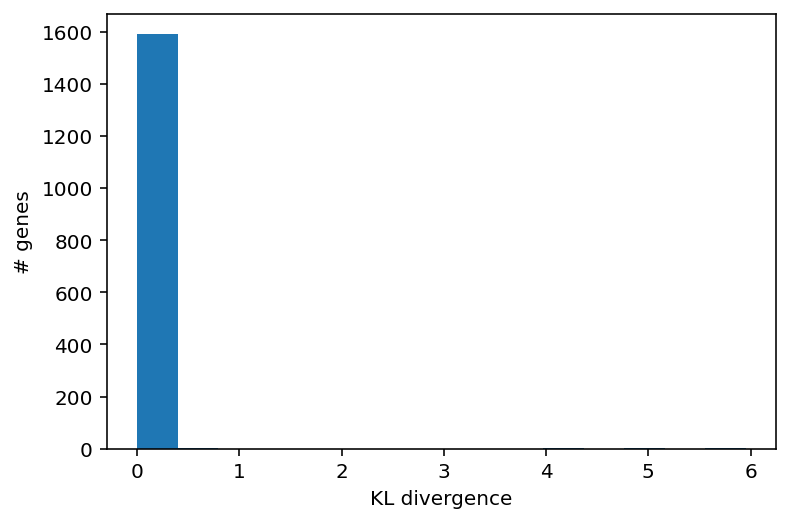

In [33]:
plot_KL(results[1])

Compute the chi-squared statistic and $p$-values for all genes at the optimal grid point.

In [34]:
# for i in results:
#     (chisq,pval) = chisq_gen(i)

Is the $p$-value higher than 0.05/`n_gen`? The gene is retained. Lower? The gene is rejected due to potential model misspecification.

Output results of the chi-square test in an array corresponding to 1 = rejected, 0 = not rejected.


In [35]:
sz = (29,55) 
figsize = (10,5)
title=True

In [36]:
print(np.array(np.reshape(results[-1].gene_rej,sz),dtype=int))

[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]


In [42]:
for i in range(len(results)):
    print(out_names[i]+': '+str(np.sum(results[i].gene_rej))+' genes of '+str(results[i].n_gen)+' have been rejected by chi-square.')

crisprsgNegCtrl4a_sgNegCtrl3b: 83 genes of 1595 have been rejected by chi-square.
crisprsgNegCtrl02093a_sgNegCtrl3b: 113 genes of 1595 have been rejected by chi-square.
crisprsgNegCtrl02093a_sgFDPSb: 58 genes of 1595 have been rejected by chi-square.
crisprsgHUS1a_sgFDPSb: 101 genes of 1595 have been rejected by chi-square.
crisprsgHUS1a_sgNegCtrl3b: 103 genes of 1595 have been rejected by chi-square.


Compare the actual raw data to the fits (points: raw data, contour plot: theoretical PMF). The fits seem to accurately reconstruct the molecular distributions. The rejected genes are HSPD1, ATRX, SLU7, COPE, and TCF4.

In [ ]:
plot_genes(result_data_1,sz,figsize,'none',log=True,title=False)

Plot the marginals. Again, the fits appear to be fairly good, although the data are sparse. Note the relatively poor fit to COPE, which supports the choice to reject.

In [50]:
plot_genes(result_data,sz,figsize,'nascent',log=False,title=False)

Test the stability of the optimum under self-consistent chi-squared testing: reject five genes, recompute the optimum based on all others, repeat. The optimum does not move.

(-7.888888888888889, -1.7999999999999998)

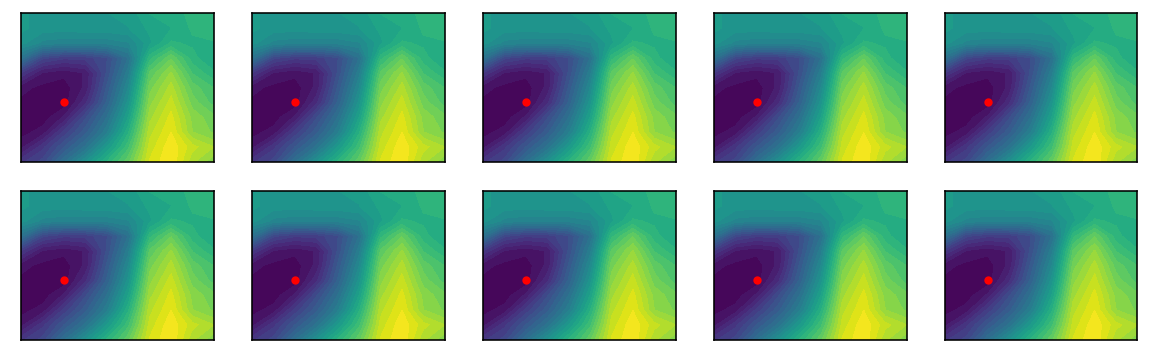

In [48]:
chisq_best_param_correction(results[0],overwrite=True) #Second control, with fewer cells

(-7.888888888888889, -1.7999999999999998)

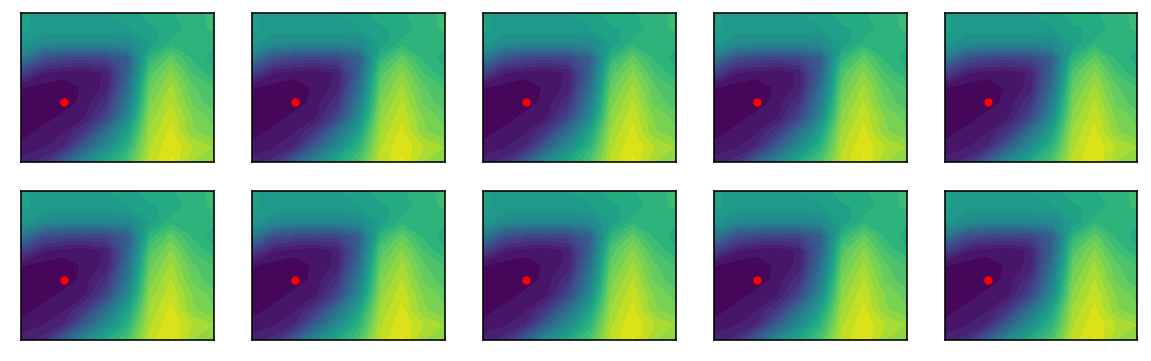

In [49]:
chisq_best_param_correction(results[1],overwrite=True) #Second control, with fewer cells
print(out_names[1])

(-8.444444444444445, -2.3499999999999996)

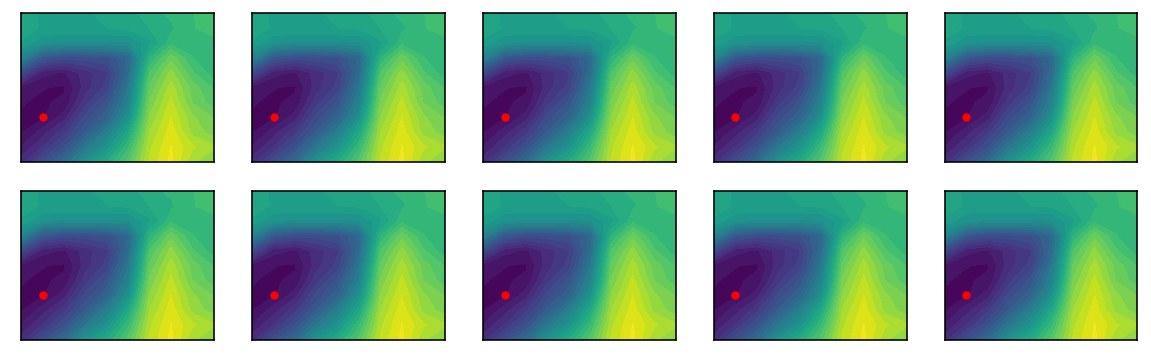

In [54]:
chisq_best_param_correction(results[2],overwrite=True)

(-8.444444444444445, -1.7999999999999998)

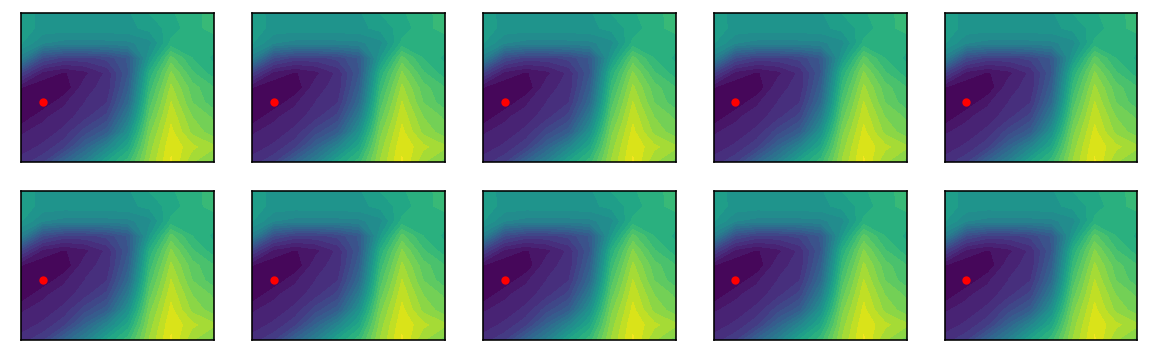

In [51]:
chisq_best_param_correction(results[3],overwrite=True) #Second control, with fewer cells

(-7.888888888888889, -1.7999999999999998)

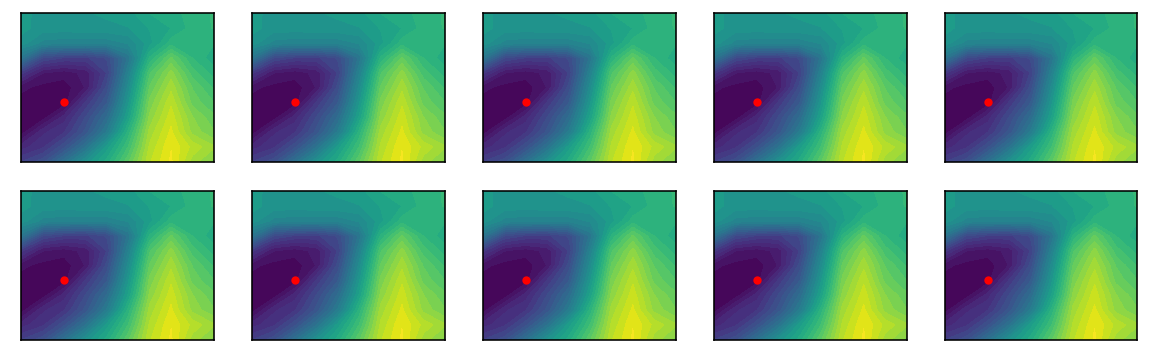

In [52]:
chisq_best_param_correction(results[4],overwrite=True) #Second control, with fewer cells

In [55]:
out_names

['crisprsgNegCtrl4a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgNegCtrl3b',
 'crisprsgNegCtrl02093a_sgFDPSb',
 'crisprsgHUS1a_sgFDPSb',
 'crisprsgHUS1a_sgNegCtrl3b']

In [56]:
#0- variance on unspliced 1-mean unspliced (look for over- or under-dispersion)
result_data_1.moment_data[:,0]/result_data_1.moment_data[:,1]-1 

array([ 0.08989863, -0.01018599,  0.11706939,  0.10882785,  0.04046319,
        0.07875034,  0.06437595,  0.85342857,  0.04850345,  0.23837336,
        0.07911191,  1.13818348,  0.01516192,  0.01501023,  0.01359475,
        0.19658519,  0.09890436,  0.07563696,  0.00522107,  0.05365334,
        0.03828089,  0.11063672, -0.00376708,  0.07913028,  0.05293455,
        0.00928353,  0.08971789,  0.02829159,  0.27159441,  0.0779046 ,
        0.15689285,  0.09743607,  0.05325443,  0.05716146,  0.28757898,
        0.0249236 ,  0.23585175,  0.18219112,  0.03989908,  0.17816711,
        0.10383072,  0.10036366, -0.01512222, -0.02283668,  0.22987029,
        0.20329477,  0.28863978,  0.10486817,  0.30487714,  0.22893599,
        0.02362154,  0.55326717,  0.40900592, -0.0105671 ,  0.1200809 ,
        0.15273295,  0.04425839,  0.02623268,  0.15886197,  0.71619177,
        0.23267862,  0.05853857,  0.37903847,  0.59202849,  0.0726365 ,
        0.01411082,  0.25219049,  0.13790723,  0.06592245,  0.09

**Haven't edited the code below yet**

###Confidence interval construction

Compute conditional 99% confidence intervals for MLEs at the optimal grid point. These are fairly narrow, as there are a lot of cells. The genes rejected by the chi-squared test are excluded. We also plot a linear fit to the parameter trends, computed using weighted linear least squares. 

In [ ]:
compute_sigma(result_data)
compute_sigma(result_data,nosamp=True)

/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


Parameter set 37 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 40 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 24 gives negative stdev; replaced with mean. (Search converged to local minimum?)
Parameter set 45 gives negative stdev; replaced with mean. (Search converged to local minimum?)


/content/seq_cme_inference.py:383: RuntimeWarning: invalid value encountered in sqrt
  errorbars[i,:] = c*np.sqrt(np.diag(hess_inv))/np.sqrt(result_data.Ncells)


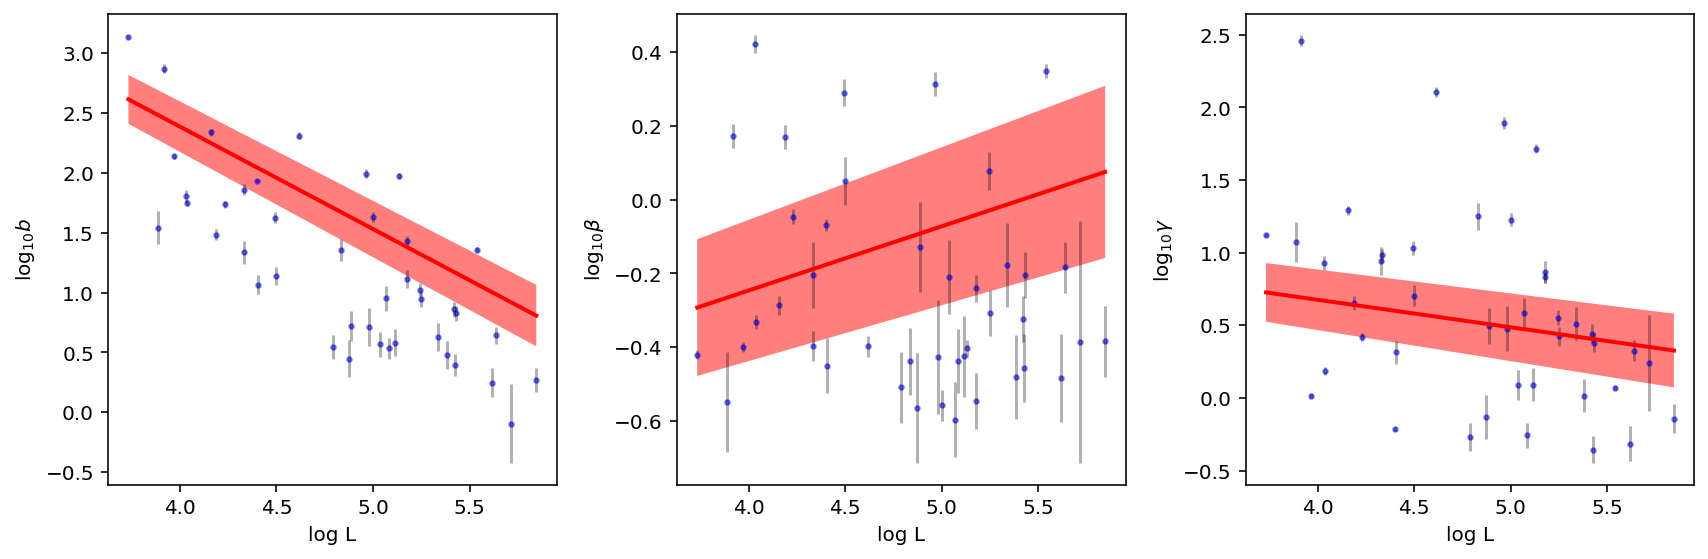

In [ ]:
for i in data:
    plot_param_L_dep(i,plot_errorbars=True,chisq_correct=True,nosamp=False)

We repeat the procedure for the noise-free fit.

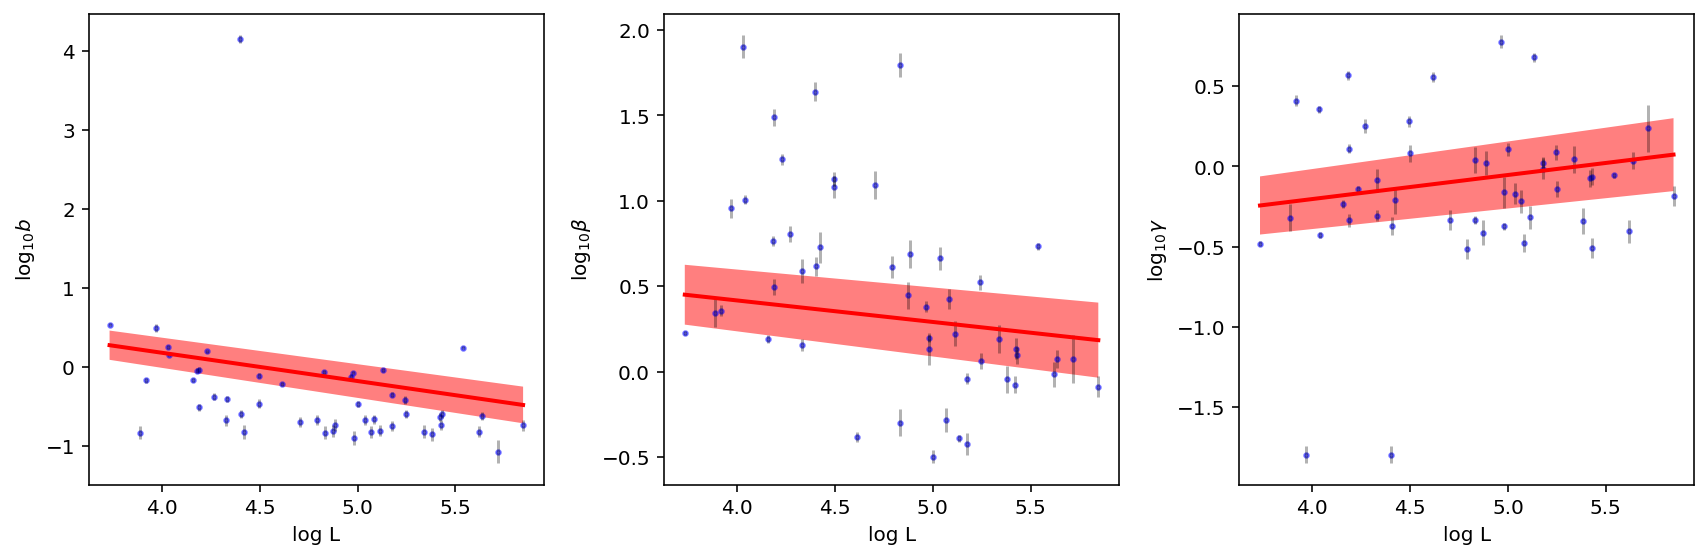

In [ ]:
_=chisq_gen(result_data,nosamp=True)
plot_param_L_dep(result_data,plot_errorbars=True,chisq_correct=True,nosamp=True)

In [ ]:
dt = time.time()-t1
print('{:.0f} seconds elapsed.'.format(dt))

NameError: ignored

In [ ]:
res1.best_ind

103

In [ ]:
res2.best_samp_params

(-7.333333333333333, -1.2)

(-7.333333333333333, -0.14999999999999947)

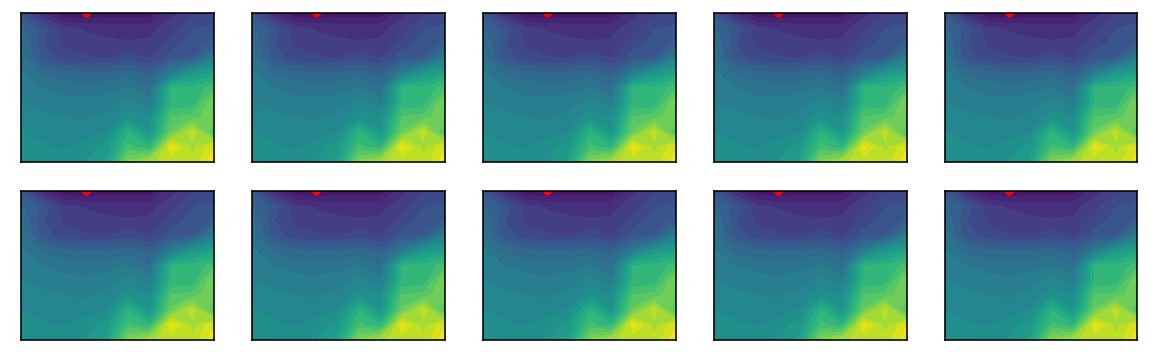

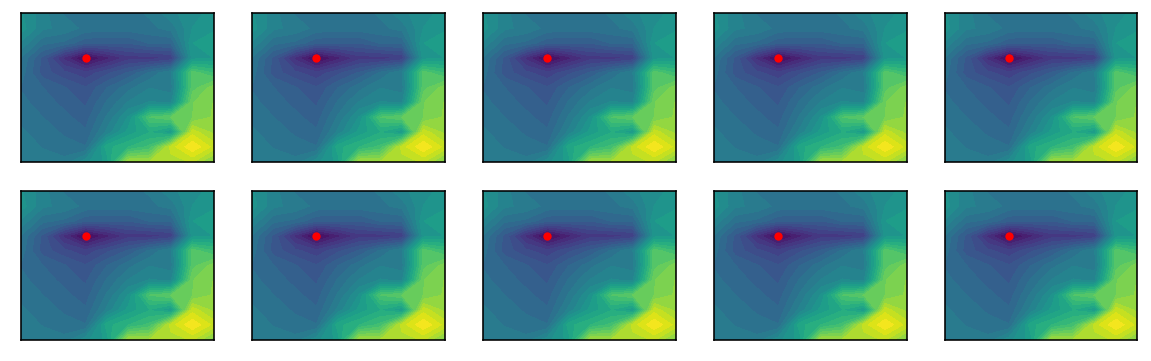

In [ ]:
res1 = import_datasets(['./gg_211118_nsc11_10x11_75gen_1/result.pickle'])
res2 = import_datasets(['./gg_211118_nsc23_10x11_75gen_1/result.pickle'])

res1.find_best_params()
res2.find_best_params()
chisq_best_param_correction(res1,overwrite=True)
chisq_best_param_correction(res2,overwrite=True)

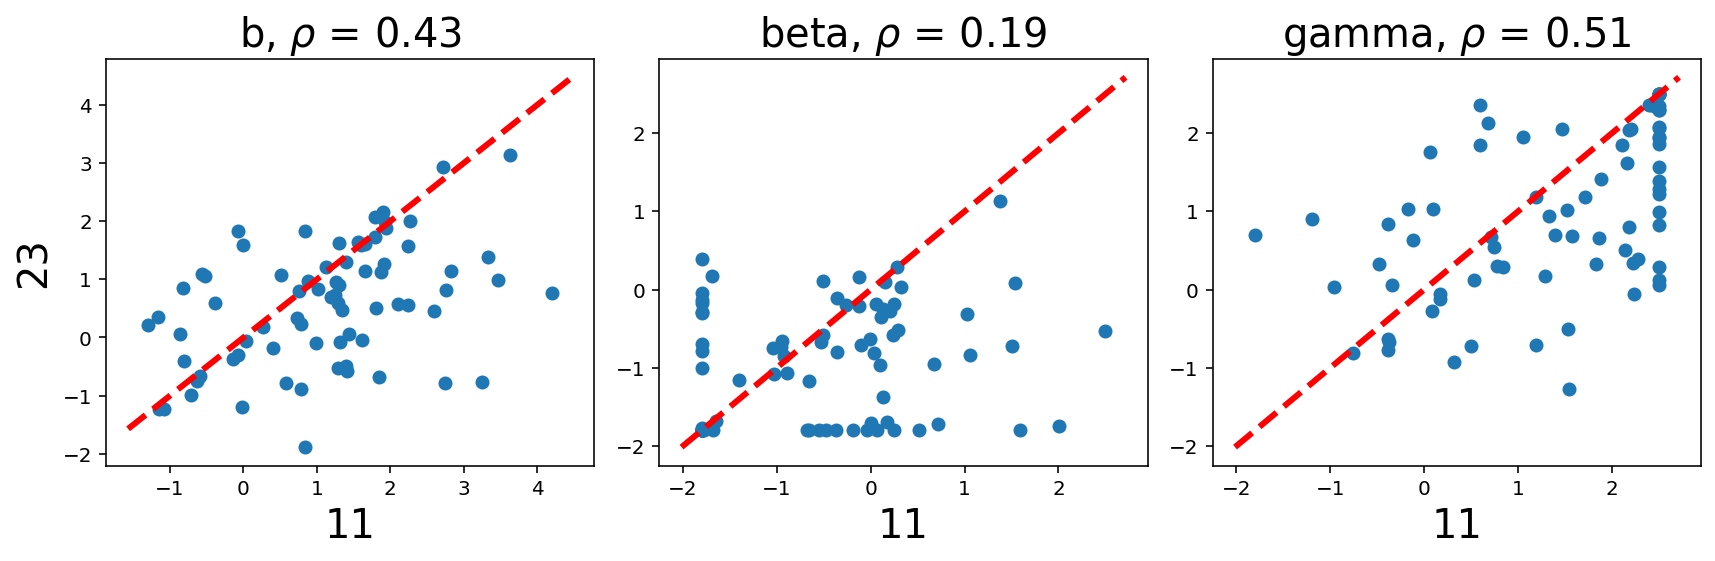

In [ ]:

fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
nbin=30
for j in range(3):
    ax1[j].scatter(res1.best_phys_params[:,j],
               res2.best_phys_params[:,j])

    fs=20
    rho=np.corrcoef(res1.best_phys_params[:,j],res2.best_phys_params[:,j])[0][1]
    ax1[j].set_title(r'{}, $\rho$ = {:.2f}'.format(param_nm[j],rho),fontsize=fs)
    xl = ax1[j].get_xlim()
    ax1[j].plot(xl,xl,'--',color='r',linewidth=3)
    ax1[j].set_xlabel(dataset_names[0],fontsize=fs)
    
    if j==0:
        ax1[j].set_ylabel(dataset_names[1],fontsize=fs)

fig1.tight_layout()


In [ ]:
param_nm = ['b','beta','gamma']
fs=10
dataset_names = ['11','23']

In [ ]:
in_ = res2.best_ind

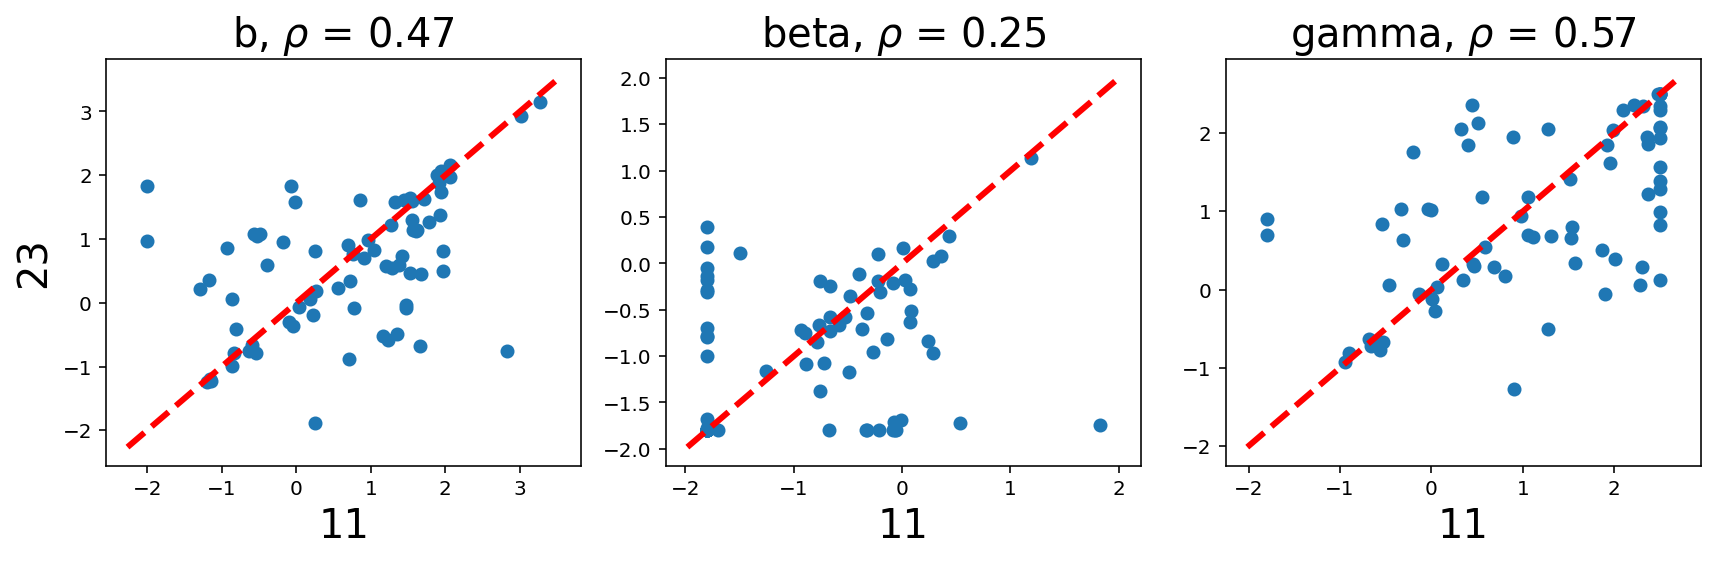

In [ ]:

fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
nbin=30
for j in range(3):
    ax1[j].scatter(res1.gene_params[in_,:,j],
               res2.gene_params[in_,:,j])

    fs=20
    rho=np.corrcoef(res1.gene_params[in_,:,j],res2.gene_params[in_,:,j])[0][1]
    ax1[j].set_title(r'{}, $\rho$ = {:.2f}'.format(param_nm[j],rho),fontsize=fs)
    xl = ax1[j].get_xlim()
    ax1[j].plot(xl,xl,'--',color='r',linewidth=3)
    ax1[j].set_xlabel(dataset_names[0],fontsize=fs)
    
    if j==0:
        ax1[j].set_ylabel(dataset_names[1],fontsize=fs)

fig1.tight_layout()


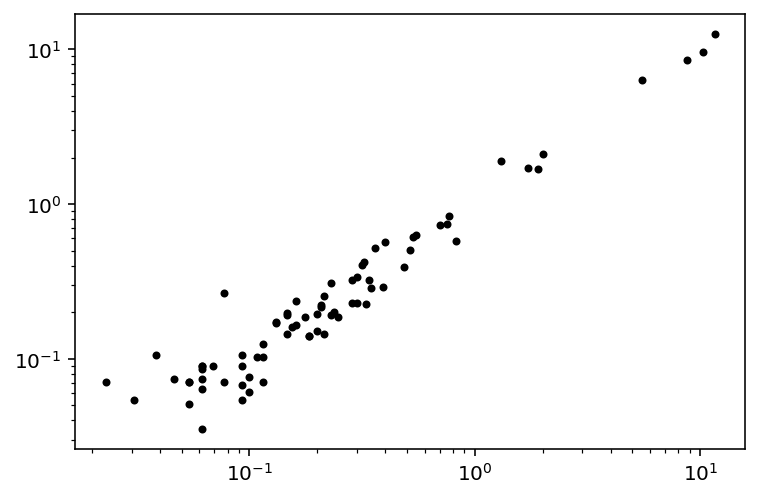

In [ ]:
plt.loglog(res1.raw_S.mean(1),res2.raw_S.mean(1),'k.')

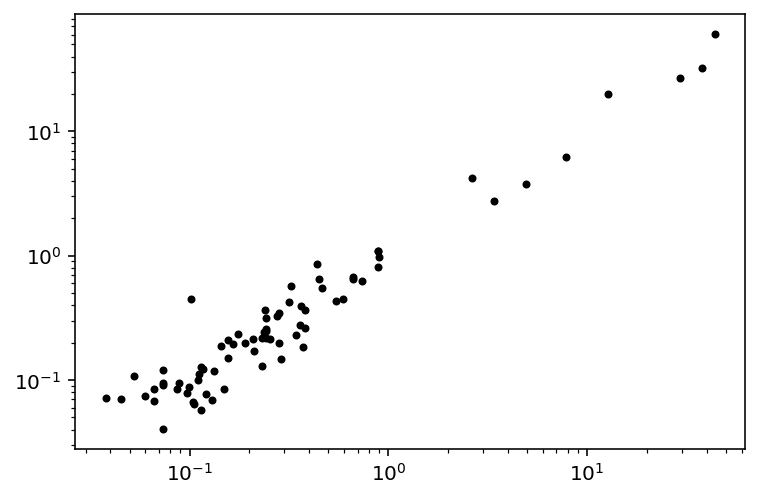

In [ ]:
plt.loglog(res1.raw_S.var(1),res2.raw_S.var(1),'k.')

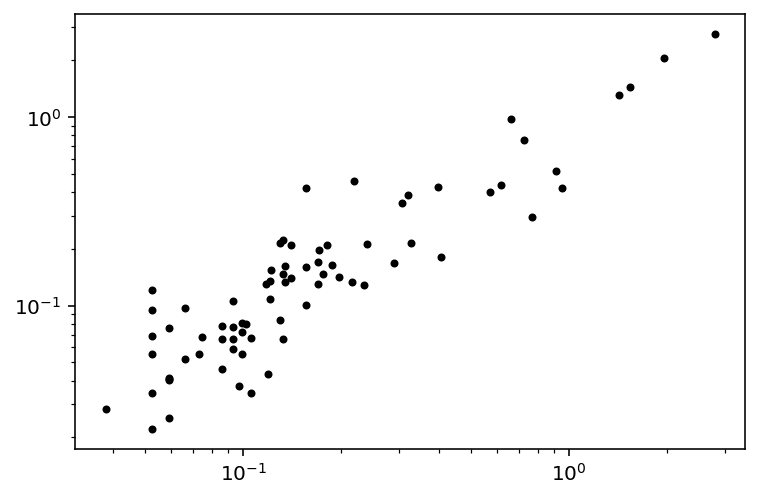

In [ ]:
plt.loglog(res1.raw_U.var(1),res2.raw_U.var(1),'k.')

In [ ]:
!zip jasefit.zip *

  adding: driver.py (deflated 70%)
  adding: example_fit.ipynb (deflated 26%)
  adding: example_input_0.txt (deflated 51%)
  adding: example_input_1.txt (deflated 51%)
  adding: example_input_dryrun.txt (deflated 51%)
  adding: gg_200524_mouse_genome_polyA_cum_1 (deflated 89%)
  adding: gg_200525_genome_polyA_cum_3 (deflated 88%)
  adding: gg210623_seq_figgen.ipynb (deflated 27%)
  adding: gg_211116_mouse_genome_len_cum_geneid_1 (deflated 95%)
  adding: gg_211118_filtered_genes.csv (deflated 27%)
  adding: gg_211118_nsc11_10x11_75gen_1/ (stored 0%)
  adding: gg_211118_nsc11_23_20x21_50gen_1/ (stored 0%)
  adding: gg_211118_nsc23_10x11_75gen_1/ (stored 0%)
  adding: gg_211118_nsc45_20x21_50gen_1/ (stored 0%)
  adding: gg_211118_selected_genes.csv (deflated 28%)
  adding: gg__filtered_genes.csv (deflated 24%)
  adding: gg__nsc11_23_10x11_50gen_1/ (stored 0%)
  adding: gg__nsc45_10x11_50gen_1/ (stored 0%)
  adding: gg__selected_genes.csv (deflated 25%)
  adding: loom_fbc/ (stored 0%)
  ad